# Generative Models

## GANs & VAE

### HW4

**Full Name:** Ali Alvandi

**SID:** 400104748

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd.variable import Variable

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [14]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [15]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [16]:
num_threads = 4
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_threads)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(z))
        return x


In [18]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x.view(-1, 784))
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var


In [19]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [22]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    model = VAE(input_dim, hidden_dim, latent_dim).to(device)
    criterion = nn.BCELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(device)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:
                inputs, _ = data
                inputs = inputs.to(device).view(-1, input_dim)
                optimizer.zero_grad()
                outputs, z_mean, z_log_var = model(inputs)
                BCE = criterion(outputs, inputs)
                KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
                loss = BCE + KLD
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.set_description(f'Epoch {epoch+1}/{num_epochs} Loss: {train_loss:.4f}')

        if epoch % 4 == 0:
            recon_images = reconstruct_images(model, sample_images)
            fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))
            for j, img in enumerate(recon_images[:4]):
                axs[j].imshow(img.reshape(28, 28).cpu().numpy(), cmap='gray')
                axs[j].axis('off')
            plt.show()

        print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

    return model

  0%|          | 0/782 [00:00<?, ?it/s]

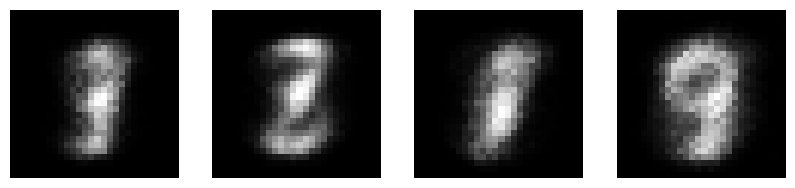

Loss: 249.2664


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 179.2708


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 162.9501


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 153.0298


  0%|          | 0/782 [00:00<?, ?it/s]

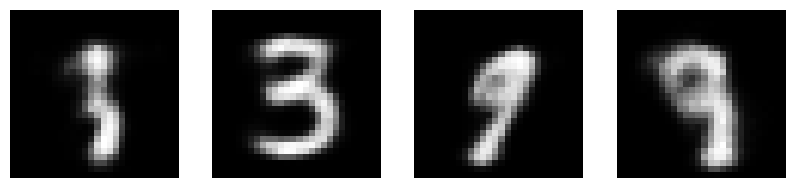

Loss: 146.2223


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 140.9601


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 137.0346


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 133.8031


  0%|          | 0/782 [00:00<?, ?it/s]

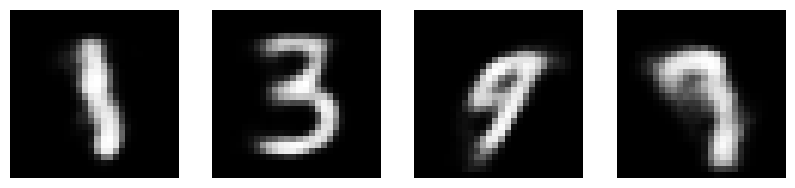

Loss: 131.1130


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 128.7863


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 126.6729


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 124.8448


  0%|          | 0/782 [00:00<?, ?it/s]

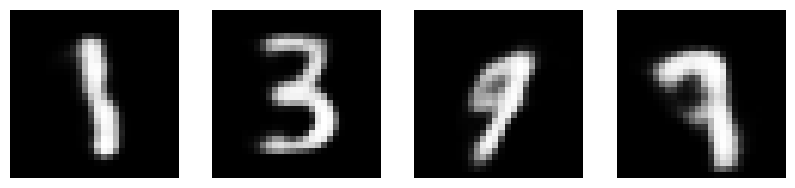

Loss: 123.2471


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 121.7536


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 120.4900


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 119.3471


  0%|          | 0/782 [00:00<?, ?it/s]

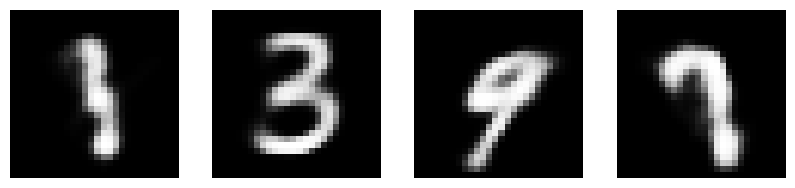

Loss: 118.3022


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 117.4347


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 116.6119


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 115.8680


  0%|          | 0/782 [00:00<?, ?it/s]

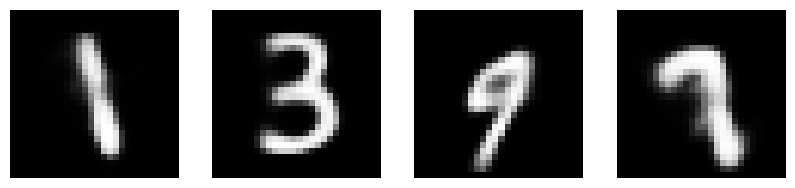

Loss: 115.2679


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.6329


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 114.0996


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 113.5494


  0%|          | 0/782 [00:00<?, ?it/s]

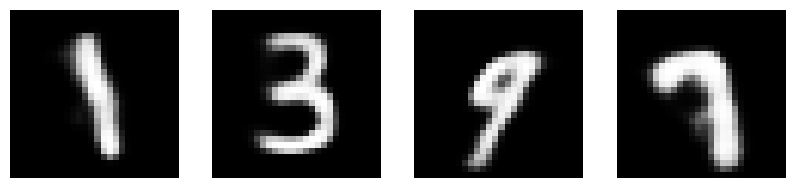

Loss: 113.0959


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.7066


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 112.2865


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.9244


  0%|          | 0/782 [00:00<?, ?it/s]

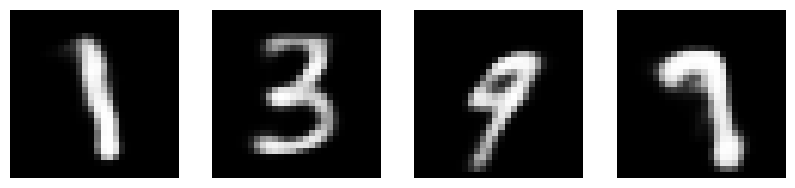

Loss: 111.6148


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.3030


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 111.0205


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.7126


  0%|          | 0/782 [00:00<?, ?it/s]

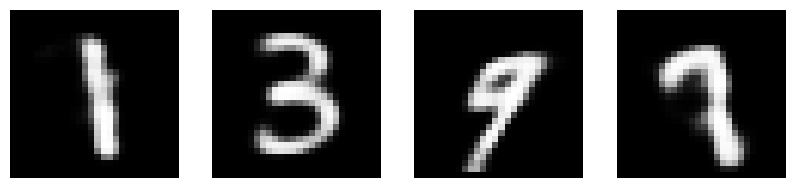

Loss: 110.4926


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 110.2751


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.9813


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.8027


  0%|          | 0/782 [00:00<?, ?it/s]

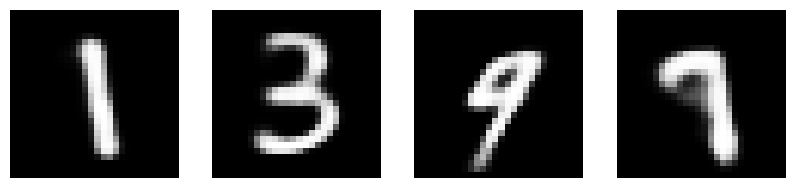

Loss: 109.5885


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.3694


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.2062


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 109.0366


  0%|          | 0/782 [00:00<?, ?it/s]

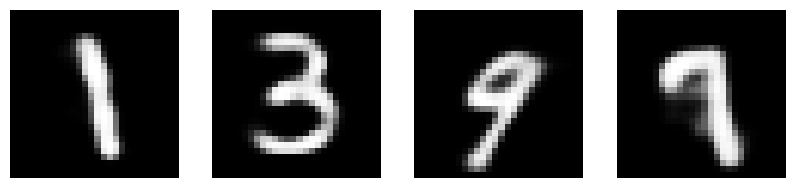

Loss: 108.8649


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.7268


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.5885


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.3980


  0%|          | 0/782 [00:00<?, ?it/s]

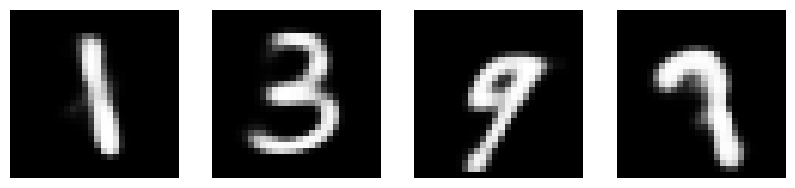

Loss: 108.2699


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.1313


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 108.0121


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 107.8840


  0%|          | 0/782 [00:00<?, ?it/s]

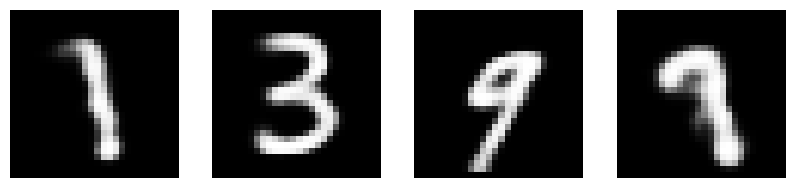

Loss: 107.7891


  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 107.6345


In [23]:
latent_dim = 50
hidden_dim = 256
input_dim = 28 * 28
learning_rate = 1e-4
num_epochs = 50

model = train_vae(train_loader, latent_dim, hidden_dim, input_dim, learning_rate, num_epochs)


# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [1]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])
    out_dir = '/kaggle/working/mnist/'
    return datasets.MNIST(root=out_dir, train=True,
                          transform=compose, download=True)

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)
train_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

In [3]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

def imgs_to_vec(imgs, img_size=28):
    return imgs.view(imgs.size(0), img_size * img_size)

def vec_to_imgs(vec):
    return vec.view(vec.size(0), 1, 28, 28)

def noise(size=128, nz=100):
    n = torch.randn(size, nz)
    return n

In [4]:
log_data = []

def log(e, E, b, B, de, ge):
    row = {
        'epoch': e, 'epochs': E,
        'batch': b, 'batches': B,
        'derror': de, 'gerror': ge,
    }

def display_logs(e, E, b, B, de, ge, dr, df, batch_size=128):
    print(f"Epoch {e+1}/{E} ({(e/E)*100:.1f}%):"
          f" [{b*batch_size}/{B*batch_size}] ({(b/B)*100:.1f}%)"
          f" D Error: {de:.4f} G Error: {ge:.4f}") 

In [5]:
def display_images(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    count = 0
    for y in range(4):
        for x in range(4):
            img = imgs[count].view(28, 28)
            axs[y][x].axis('off')
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()

In [6]:
class Generator(nn.Module):
    """ 3 hidden layer generative nn. """
    def __init__(self, batch_size=100, img_size=28):
        super(Generator, self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(batch_size, 256),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(1024, img_size * img_size),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
# class Generator(nn.Module):
#     def __init__(self, nz=100, ngf=64, nc=1):
#         super(Generator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(nz, ngf * 4 * 7 * 7),
#             nn.ReLU(True),
#             nn.BatchNorm1d(ngf * 4 * 7 * 7),
#             nn.Unflatten(1, (ngf * 4, 7, 7)),

#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, stride=2, padding=1, bias=False),
#             nn.ReLU(True),
#             nn.BatchNorm2d(ngf * 2),

#             nn.ConvTranspose2d(ngf * 2, ngf, 4, stride=2, padding=1, bias=False),
#             nn.ReLU(True),
#             nn.BatchNorm2d(ngf),

#             nn.ConvTranspose2d(ngf, nc, 3, stride=1, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, z):
#         return self.model(z)


class Discriminator(nn.Module):
    """ 3 hidden layer discriminative nn. """
    def __init__(self, n_out=1, img_size=28):
        super(Discriminator, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
def train_discriminator(dmodel, optimizer, loss_func, real_data, fake_data):
    optimizer.zero_grad()
    # Train on real data
    pred_real = dmodel(real_data)
    error_real = loss_func(pred_real, real_data_target(real_data.size(0)))
    error_real.backward()
    # Train on fake data
    pred_fake = dmodel(fake_data)
    error_fake = loss_func(pred_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    # Update weights
    optimizer.step()
    # Return error
    return error_real + error_fake, pred_real, pred_fake

In [8]:
def train_generator(dmodel, optimizer, loss_func, fake_data):
    optimizer.zero_grad()
    pred = dmodel(fake_data)
    error = loss_func(pred, real_data_target(pred.size(0)))
    error.backward()
    optimizer.step()
    return error

In [9]:
NUM_BATCHES = len(train_loader)
DISPLAY_EVERY = 1000

num_samples = 16
test_noise = noise(num_samples)
test_noise

tensor([[-0.6867,  0.4828, -0.7219,  ...,  0.1915, -0.1449,  1.2840],
        [-0.1909, -0.0725, -0.0494,  ...,  0.0507, -0.5862,  0.4525],
        [-0.0688, -0.3240, -1.1878,  ..., -0.6756, -1.9109,  0.9411],
        ...,
        [ 0.4690, -1.5918, -0.3200,  ..., -1.5822, -0.6788, -1.4534],
        [ 0.3371, -0.1547,  0.0171,  ..., -0.0686, -1.1797, -1.3569],
        [-0.8473, -0.0506,  2.2767,  ...,  1.5640,  1.1944,  0.1816]])

In [10]:
discriminator = Discriminator()
generator = Generator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
EPOCHS = 200
NUM_BATCHES = len(train_loader)
DISPLAY_EVERY = 1000


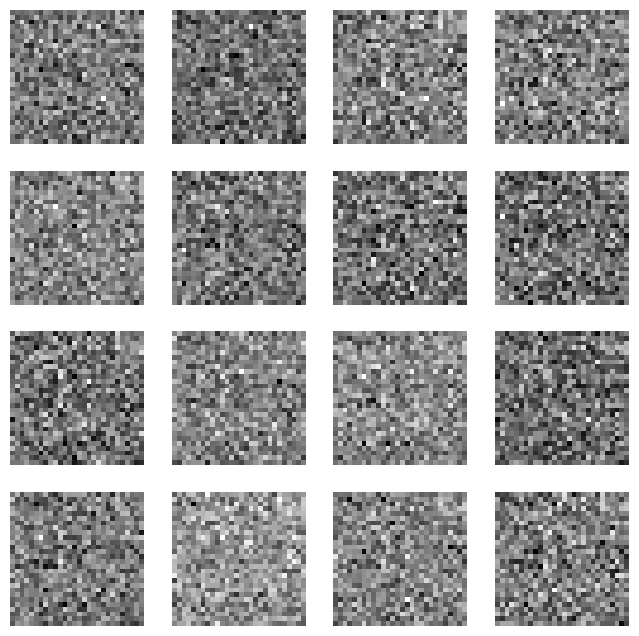

Epoch 1/200 (0.0%): [0/60032] (0.0%) D Error: 1.3949 G Error: 0.6858


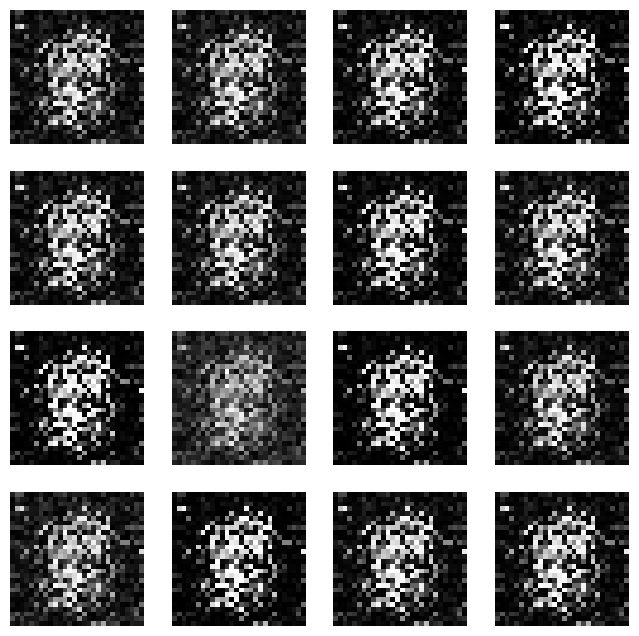

Epoch 2/200 (0.5%): [0/60032] (0.0%) D Error: 2.1998 G Error: 1.1094


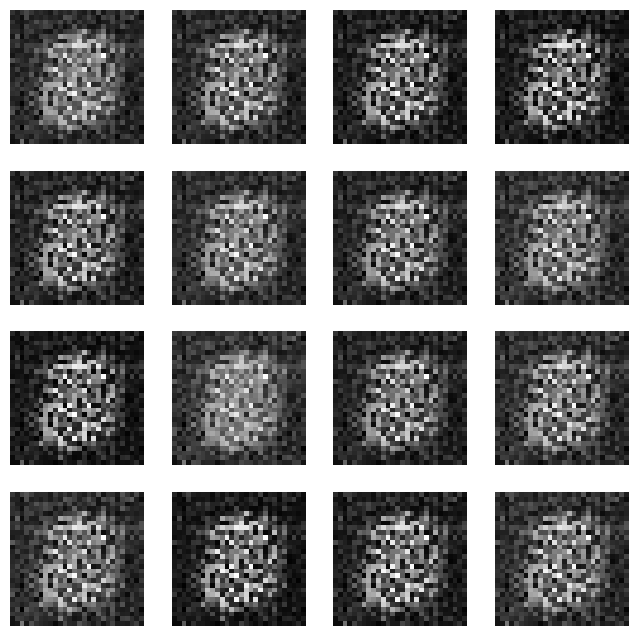

Epoch 3/200 (1.0%): [0/60032] (0.0%) D Error: 0.6154 G Error: 3.8017


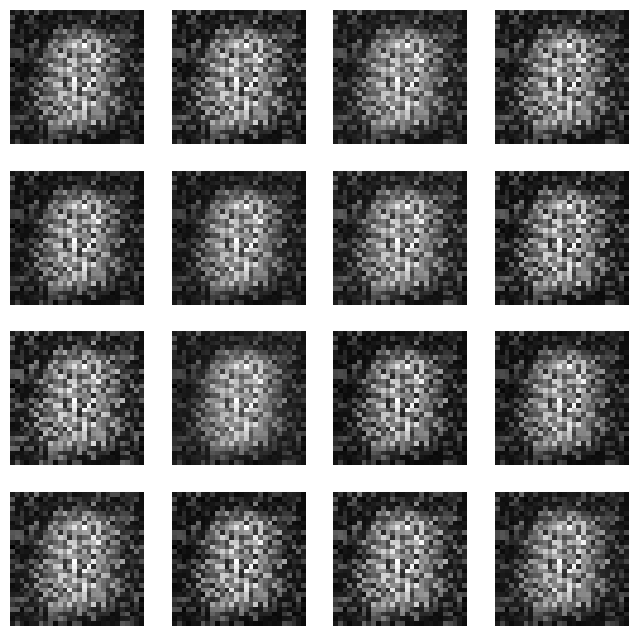

Epoch 4/200 (1.5%): [0/60032] (0.0%) D Error: 0.6194 G Error: 1.6661


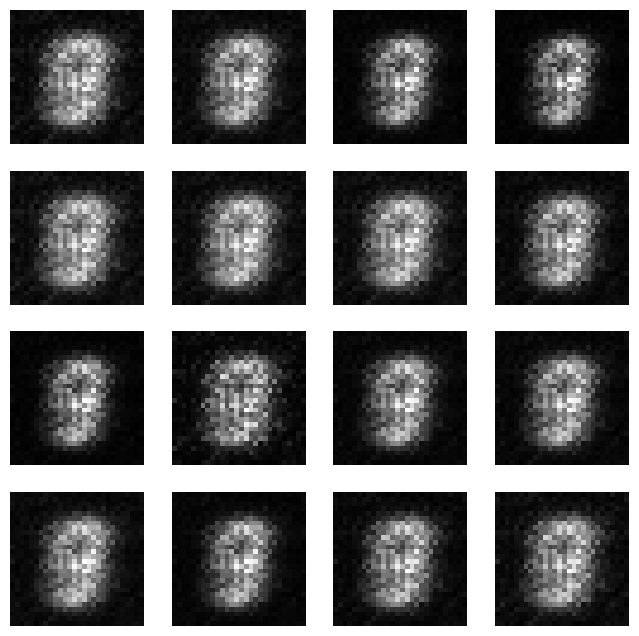

Epoch 5/200 (2.0%): [0/60032] (0.0%) D Error: 0.6782 G Error: 2.0683


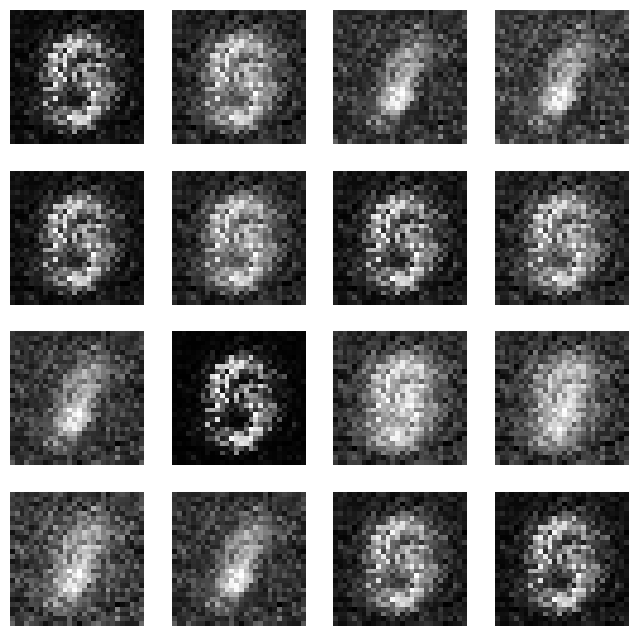

Epoch 6/200 (2.5%): [0/60032] (0.0%) D Error: 0.4914 G Error: 3.6023


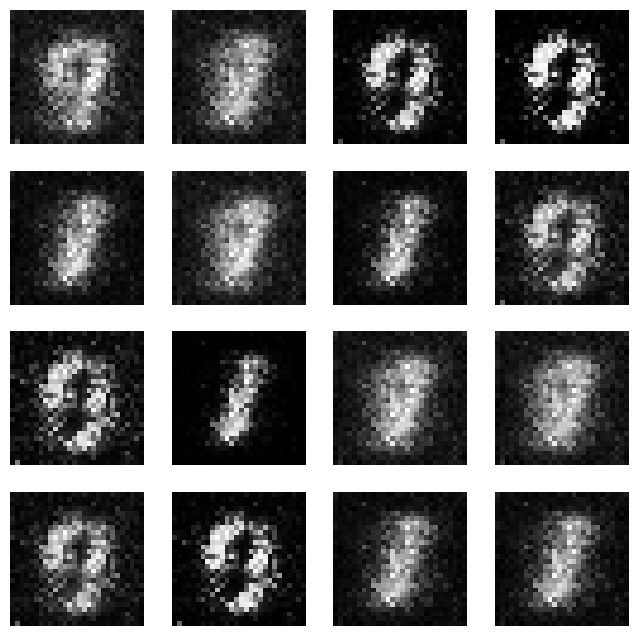

Epoch 7/200 (3.0%): [0/60032] (0.0%) D Error: 0.4976 G Error: 2.6036


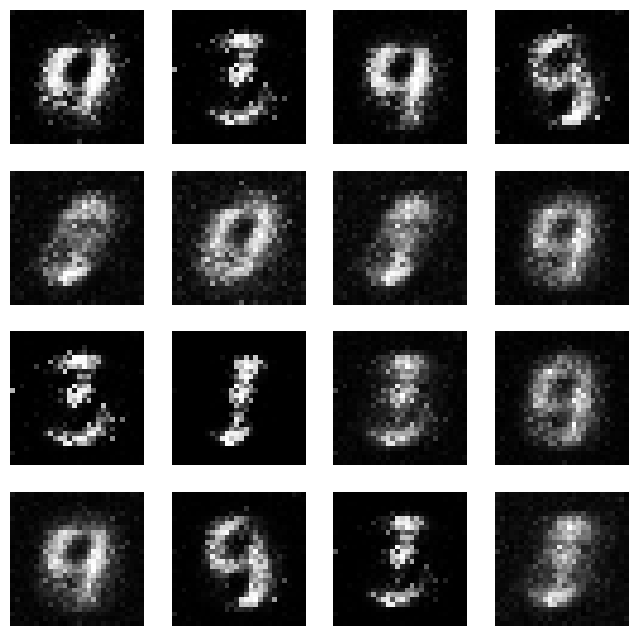

Epoch 8/200 (3.5%): [0/60032] (0.0%) D Error: 0.7784 G Error: 2.4303


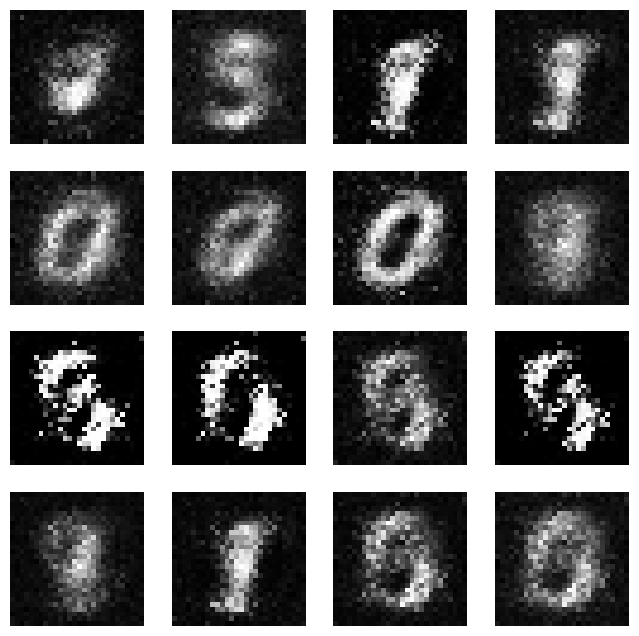

Epoch 9/200 (4.0%): [0/60032] (0.0%) D Error: 0.4537 G Error: 2.8528


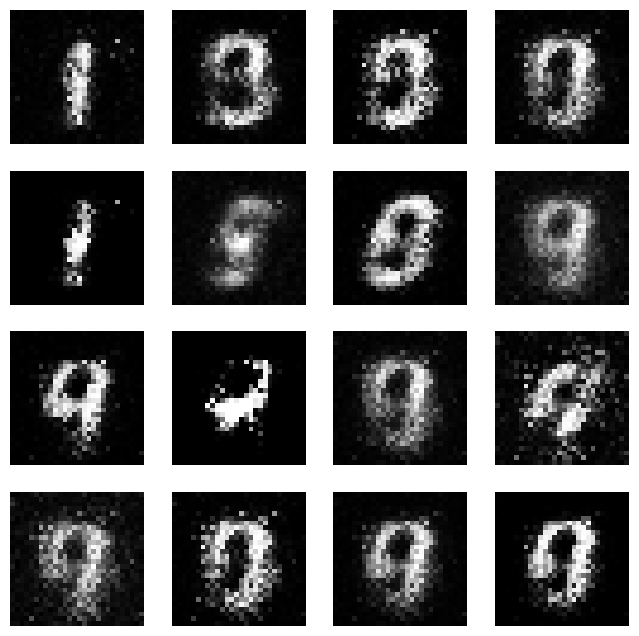

Epoch 10/200 (4.5%): [0/60032] (0.0%) D Error: 0.5884 G Error: 2.4680


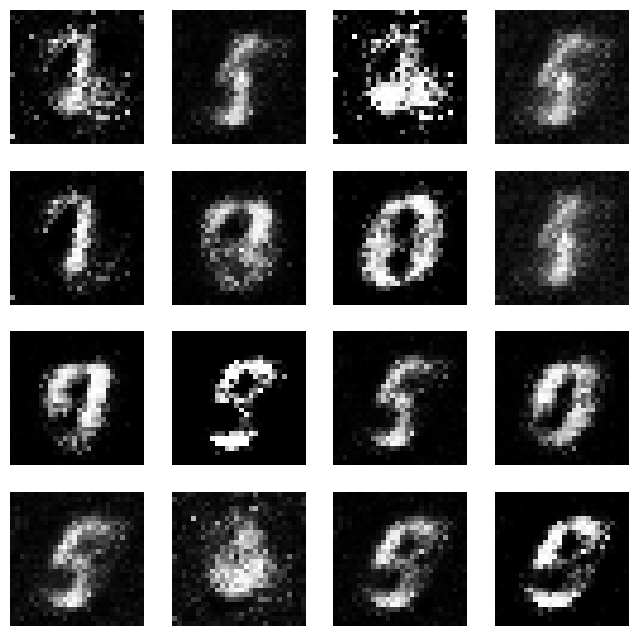

Epoch 11/200 (5.0%): [0/60032] (0.0%) D Error: 0.6706 G Error: 2.3052


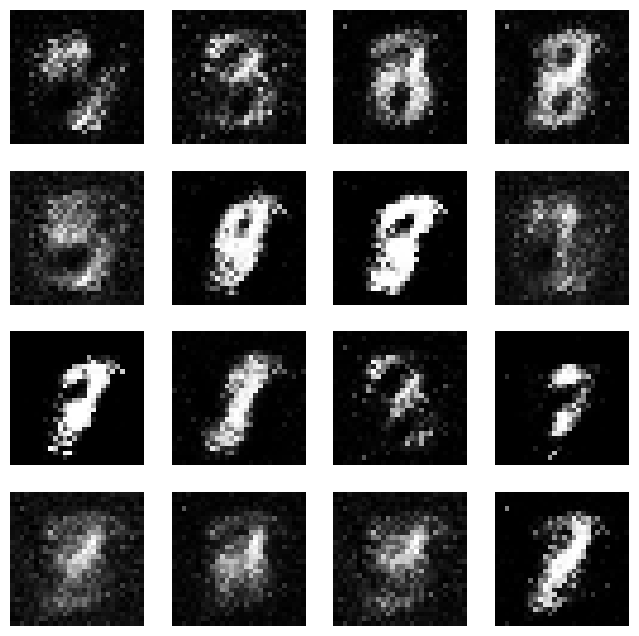

Epoch 12/200 (5.5%): [0/60032] (0.0%) D Error: 0.6776 G Error: 2.3706


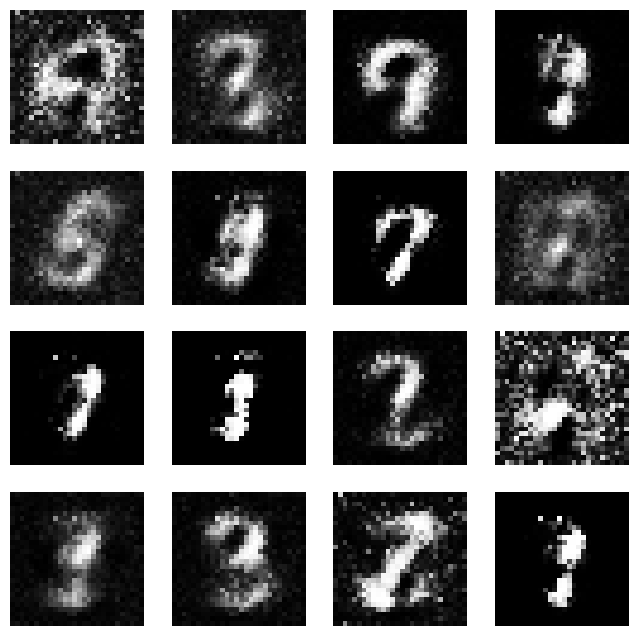

Epoch 13/200 (6.0%): [0/60032] (0.0%) D Error: 0.6380 G Error: 2.2639


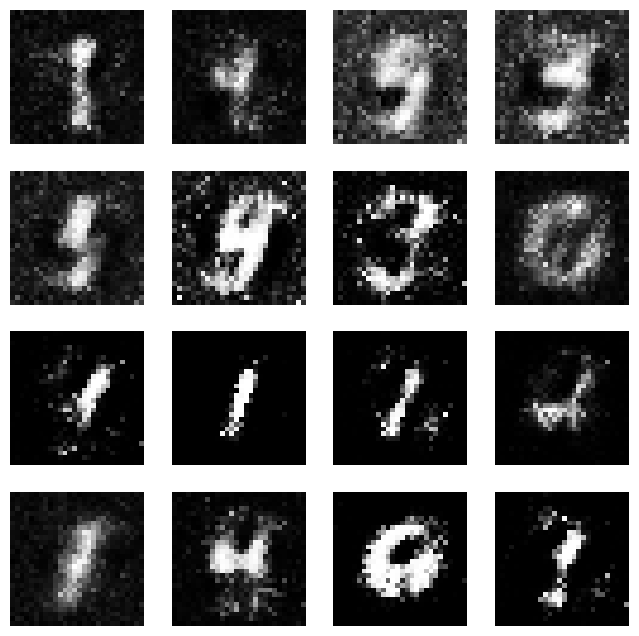

Epoch 14/200 (6.5%): [0/60032] (0.0%) D Error: 0.8387 G Error: 2.0229


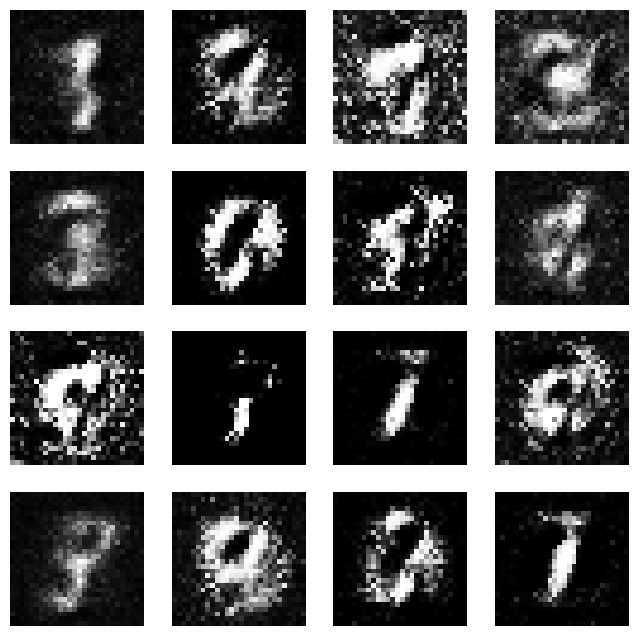

Epoch 15/200 (7.0%): [0/60032] (0.0%) D Error: 0.9558 G Error: 1.7254


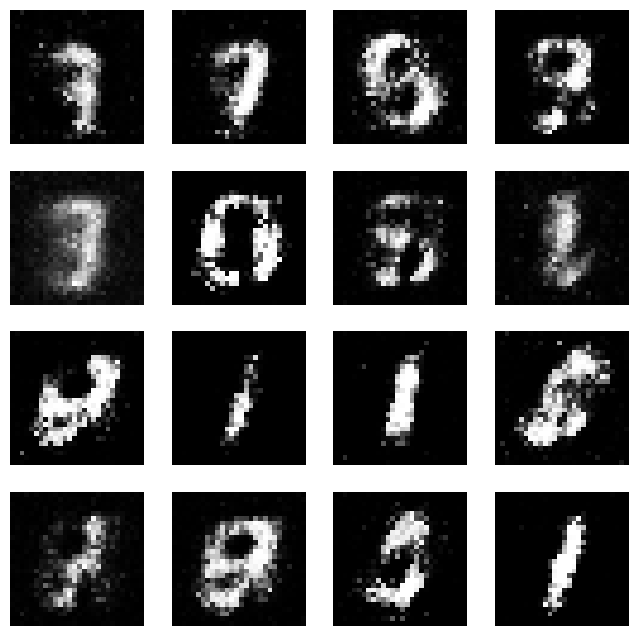

Epoch 16/200 (7.5%): [0/60032] (0.0%) D Error: 1.0743 G Error: 1.7443


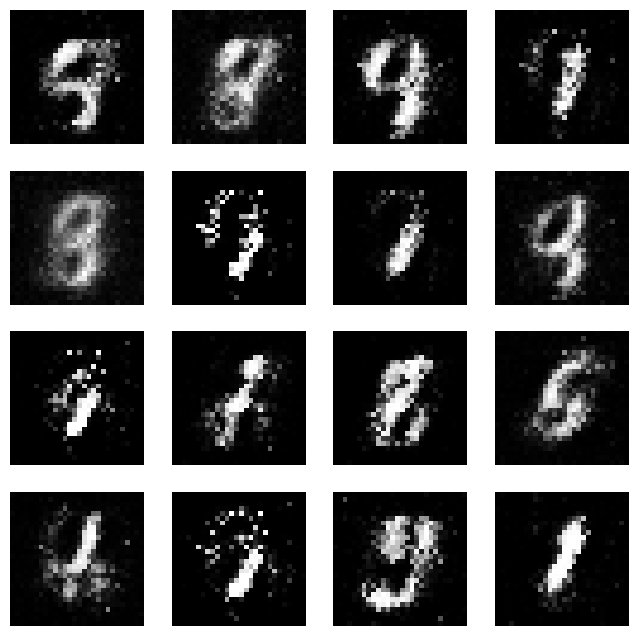

Epoch 17/200 (8.0%): [0/60032] (0.0%) D Error: 0.7472 G Error: 2.1799


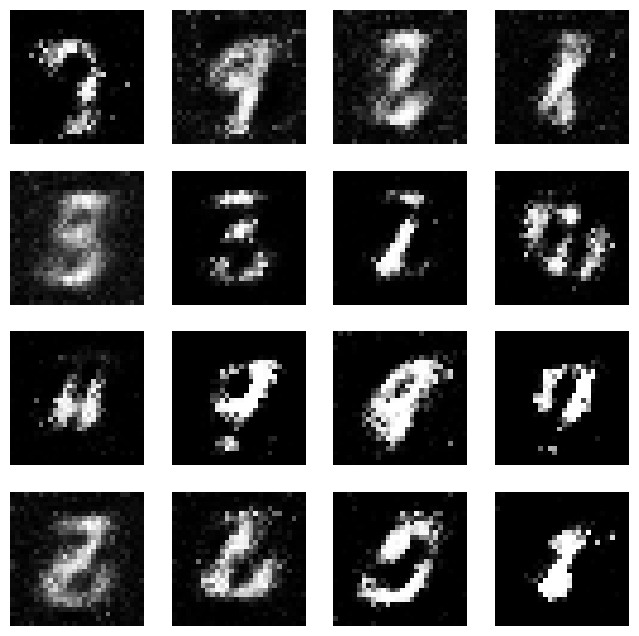

Epoch 18/200 (8.5%): [0/60032] (0.0%) D Error: 0.5445 G Error: 2.4120


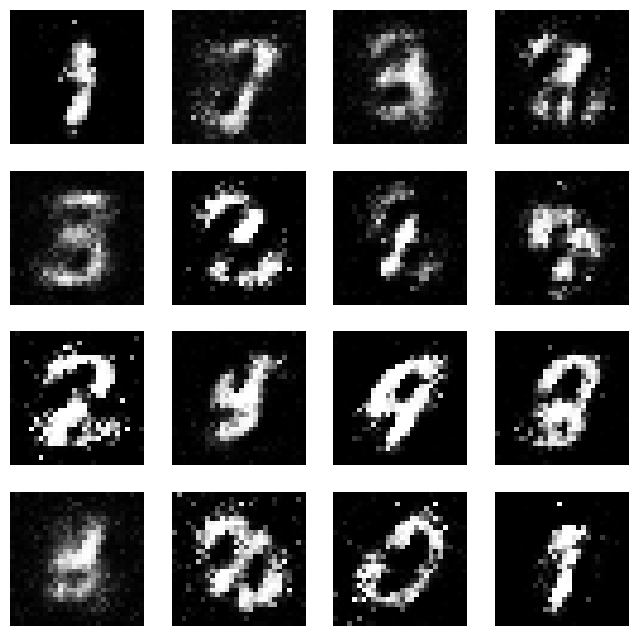

Epoch 19/200 (9.0%): [0/60032] (0.0%) D Error: 0.8274 G Error: 1.6022


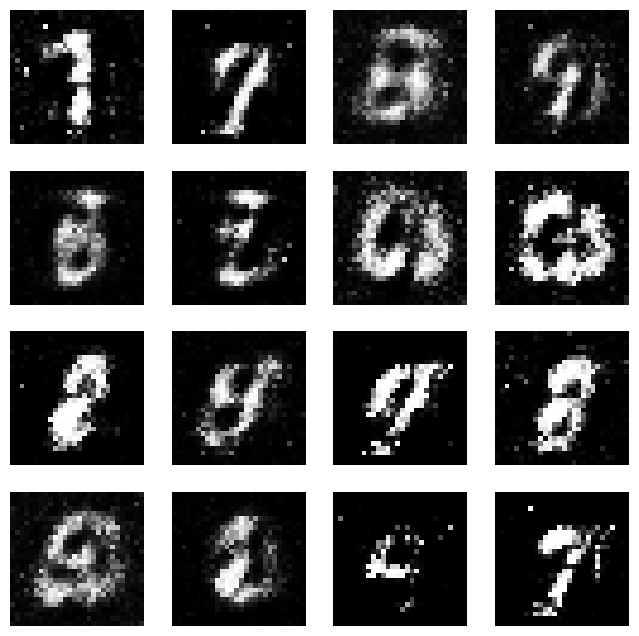

Epoch 20/200 (9.5%): [0/60032] (0.0%) D Error: 0.7752 G Error: 2.0401


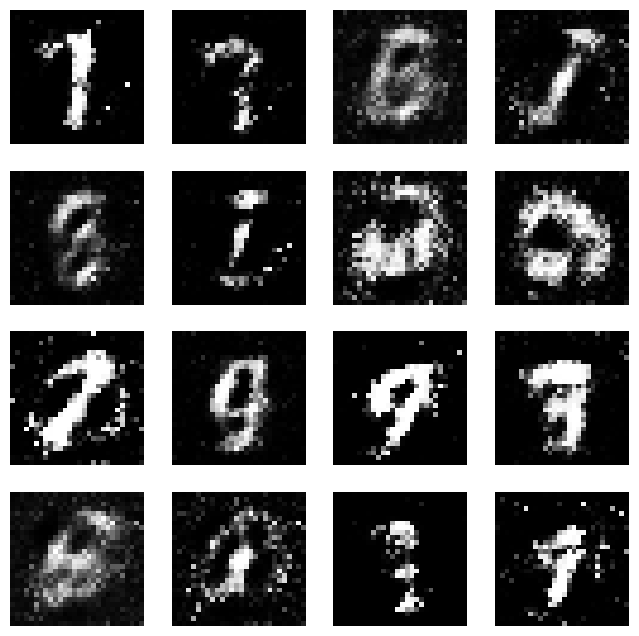

Epoch 21/200 (10.0%): [0/60032] (0.0%) D Error: 0.6852 G Error: 1.9239


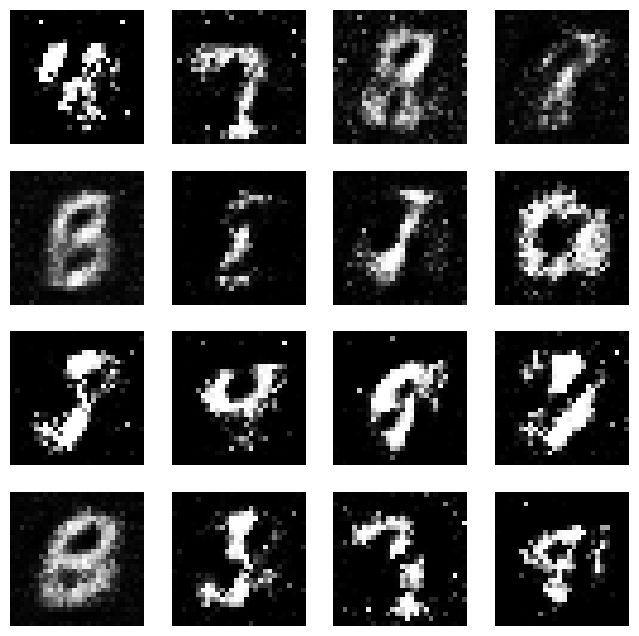

Epoch 22/200 (10.5%): [0/60032] (0.0%) D Error: 0.8091 G Error: 1.7965


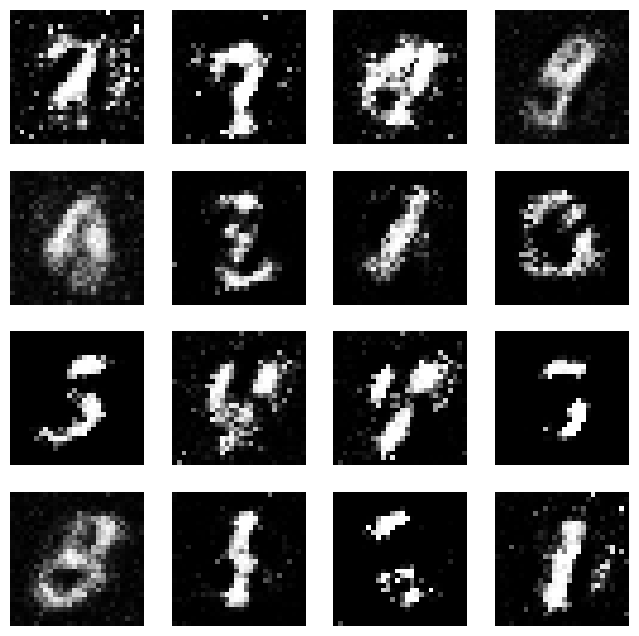

Epoch 23/200 (11.0%): [0/60032] (0.0%) D Error: 0.7009 G Error: 2.1942


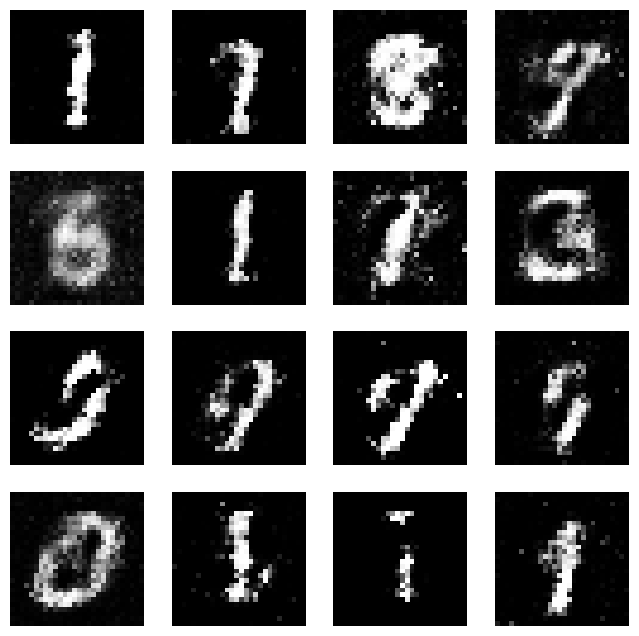

Epoch 24/200 (11.5%): [0/60032] (0.0%) D Error: 0.9782 G Error: 1.7604


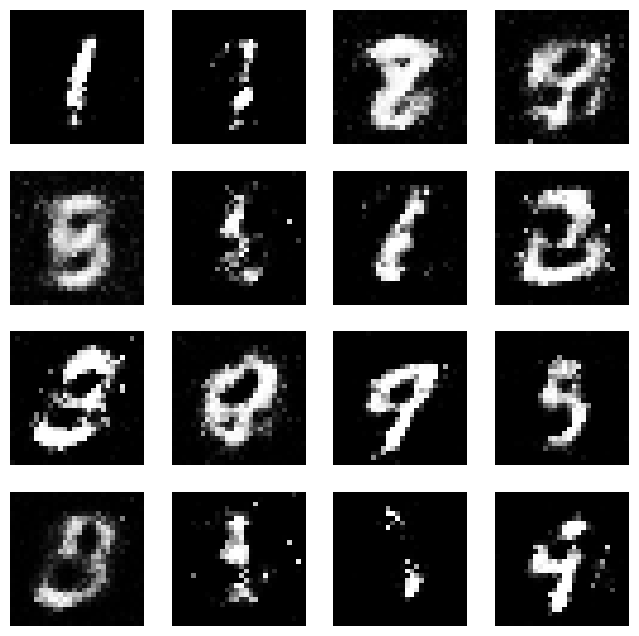

Epoch 25/200 (12.0%): [0/60032] (0.0%) D Error: 0.9556 G Error: 2.0505


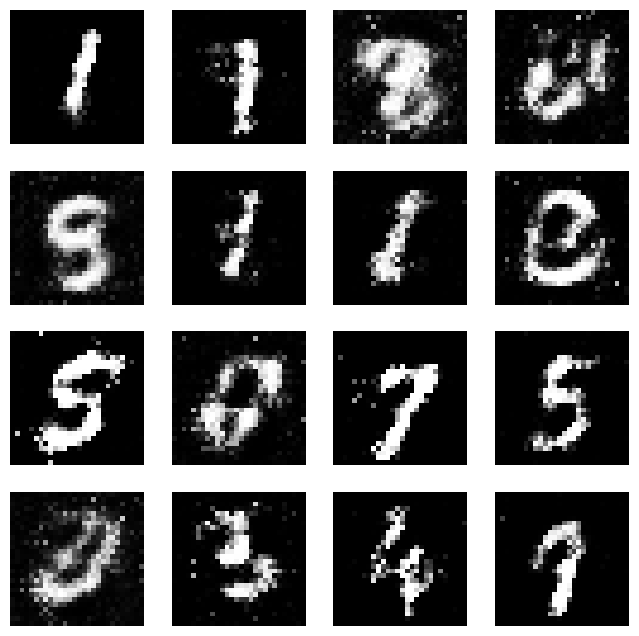

Epoch 26/200 (12.5%): [0/60032] (0.0%) D Error: 0.9934 G Error: 1.2708


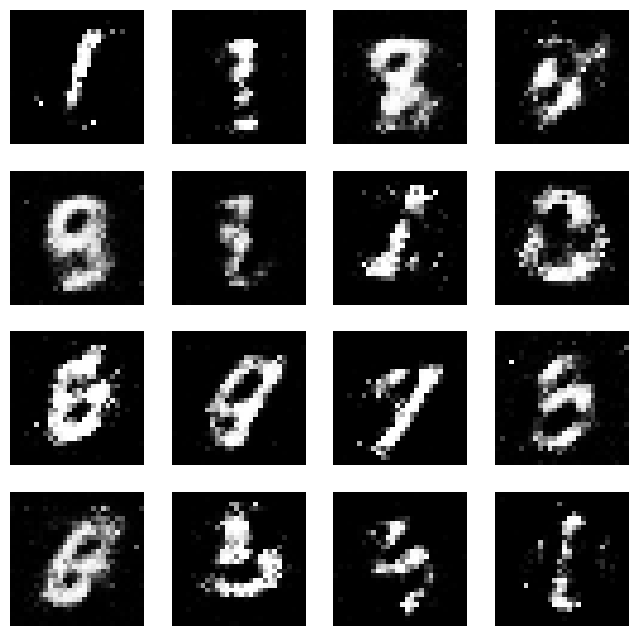

Epoch 27/200 (13.0%): [0/60032] (0.0%) D Error: 0.8998 G Error: 2.1629


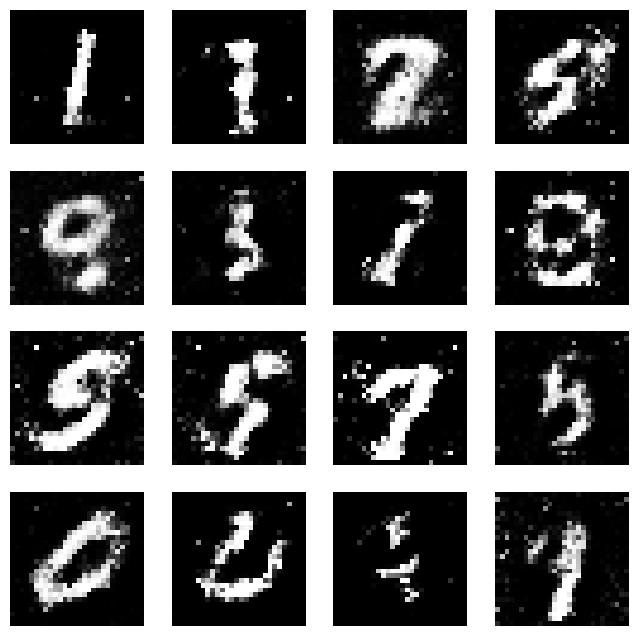

Epoch 28/200 (13.5%): [0/60032] (0.0%) D Error: 0.8017 G Error: 1.5301


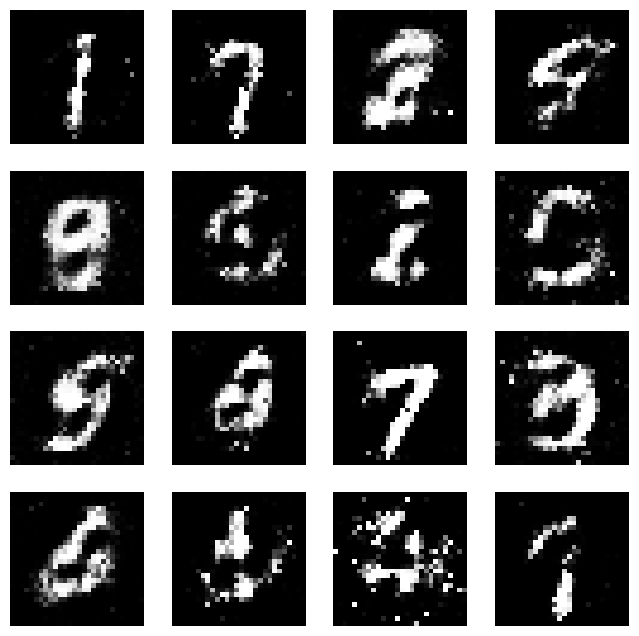

Epoch 29/200 (14.0%): [0/60032] (0.0%) D Error: 0.7316 G Error: 1.6760


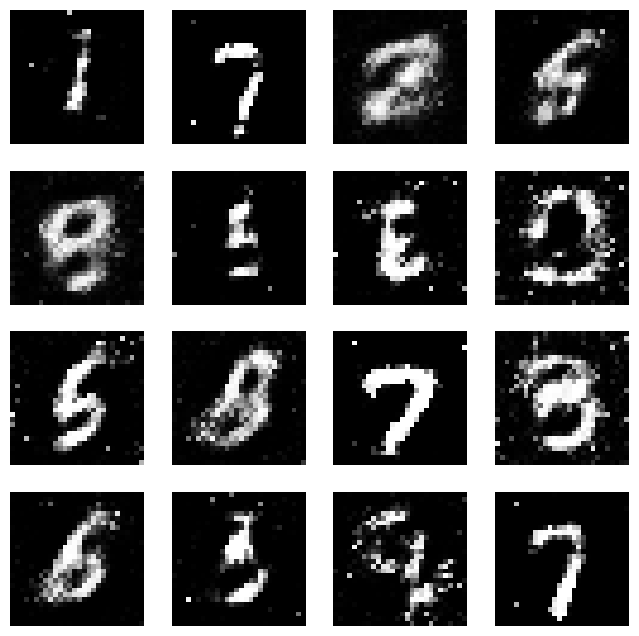

Epoch 30/200 (14.5%): [0/60032] (0.0%) D Error: 1.1301 G Error: 1.8008


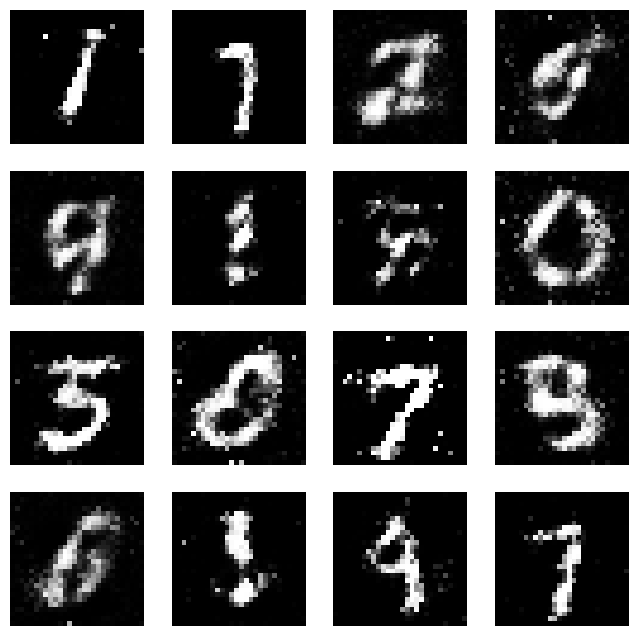

Epoch 31/200 (15.0%): [0/60032] (0.0%) D Error: 1.0493 G Error: 1.6359


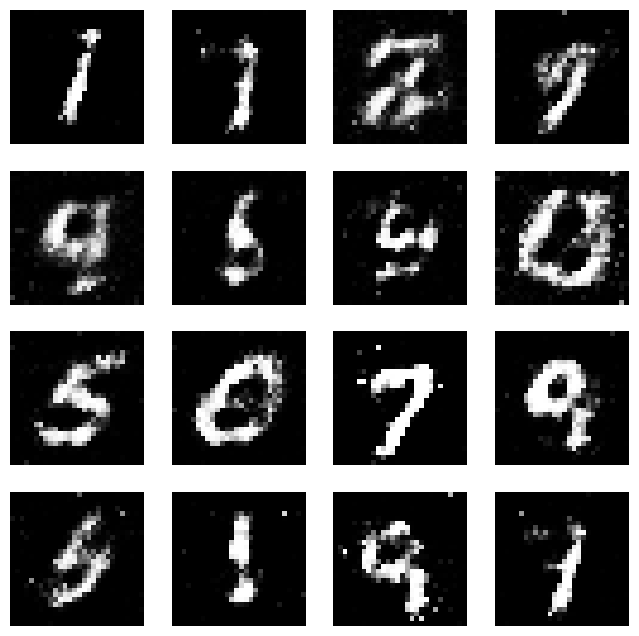

Epoch 32/200 (15.5%): [0/60032] (0.0%) D Error: 1.0393 G Error: 1.4390


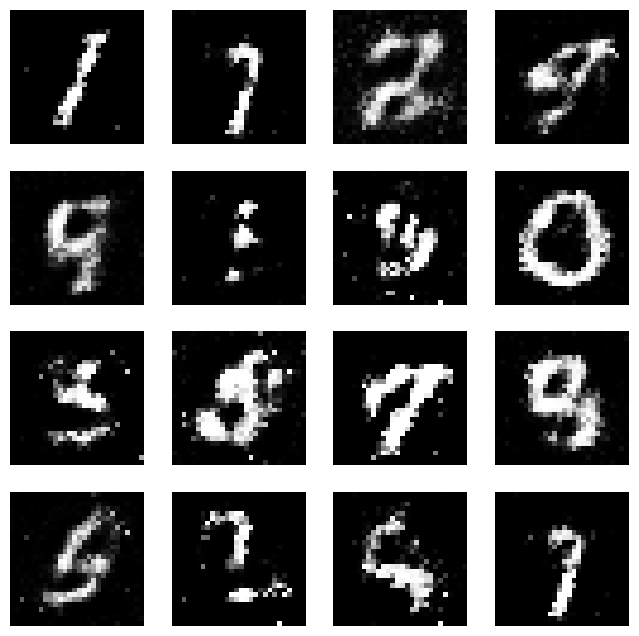

Epoch 33/200 (16.0%): [0/60032] (0.0%) D Error: 0.8817 G Error: 1.4873


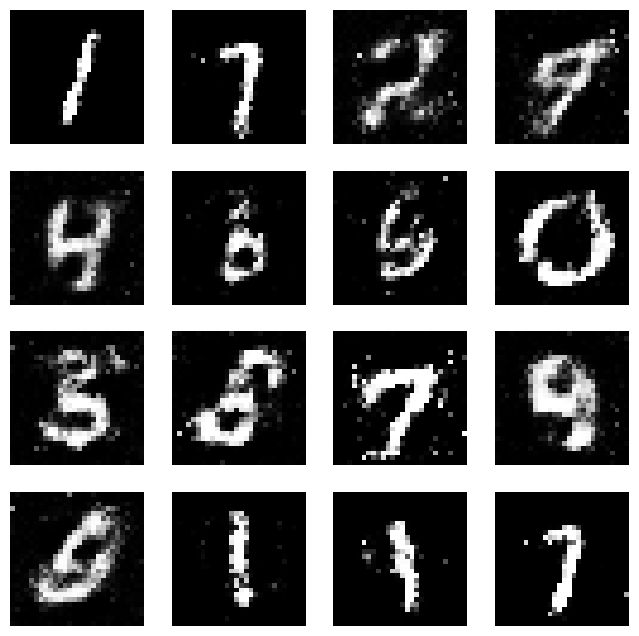

Epoch 34/200 (16.5%): [0/60032] (0.0%) D Error: 0.9541 G Error: 1.5069


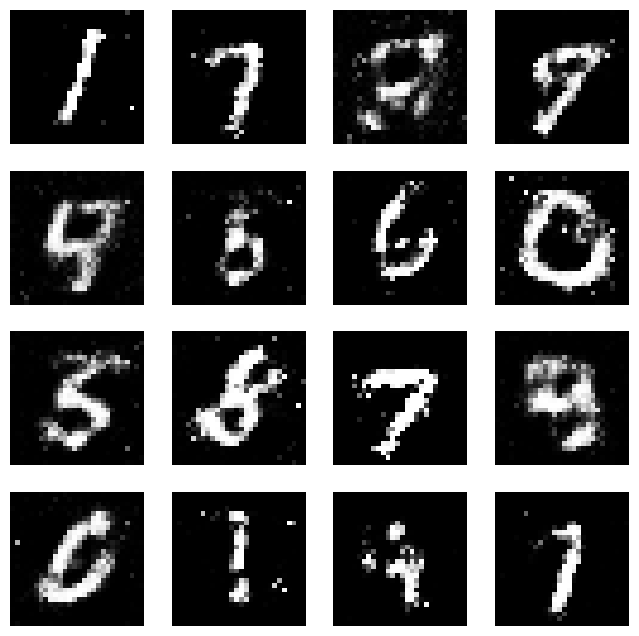

Epoch 35/200 (17.0%): [0/60032] (0.0%) D Error: 0.8124 G Error: 1.9782


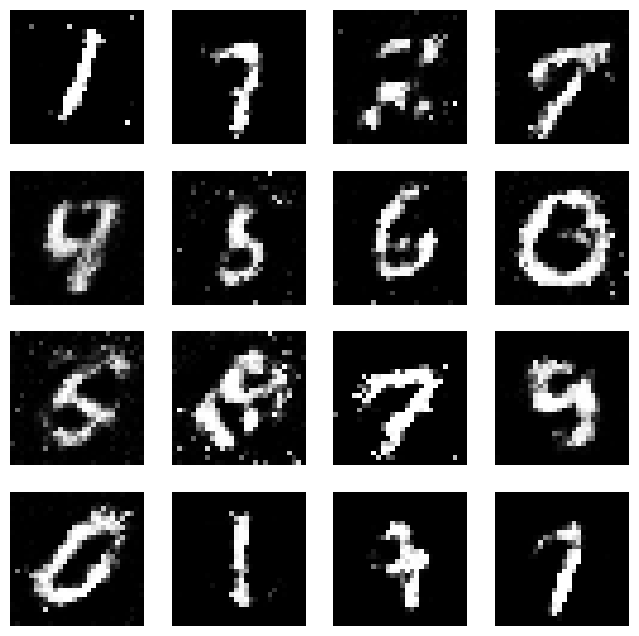

Epoch 36/200 (17.5%): [0/60032] (0.0%) D Error: 1.1426 G Error: 1.2271


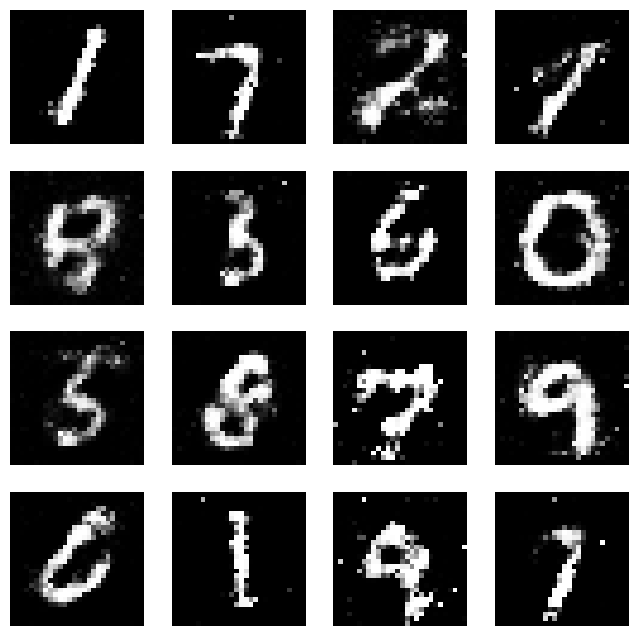

Epoch 37/200 (18.0%): [0/60032] (0.0%) D Error: 1.1946 G Error: 1.4050


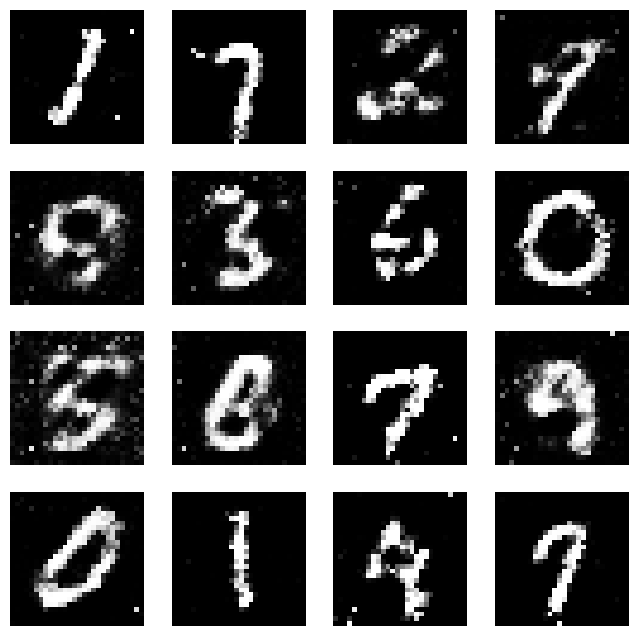

Epoch 38/200 (18.5%): [0/60032] (0.0%) D Error: 1.1077 G Error: 1.1941


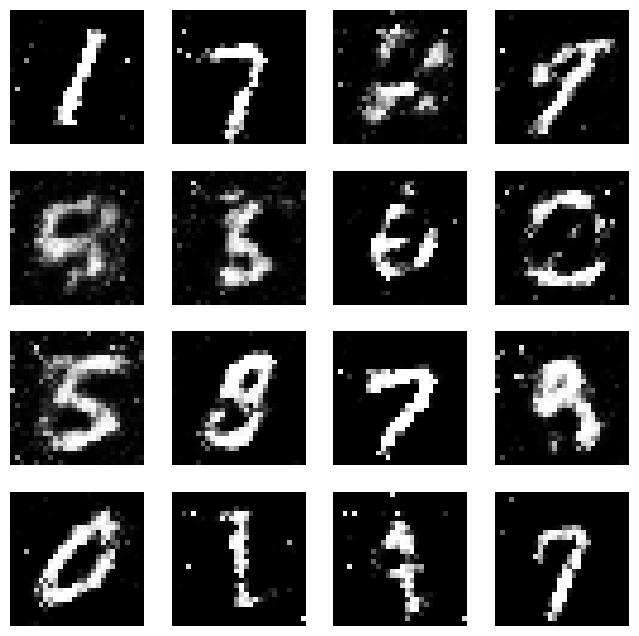

Epoch 39/200 (19.0%): [0/60032] (0.0%) D Error: 0.8700 G Error: 1.7139


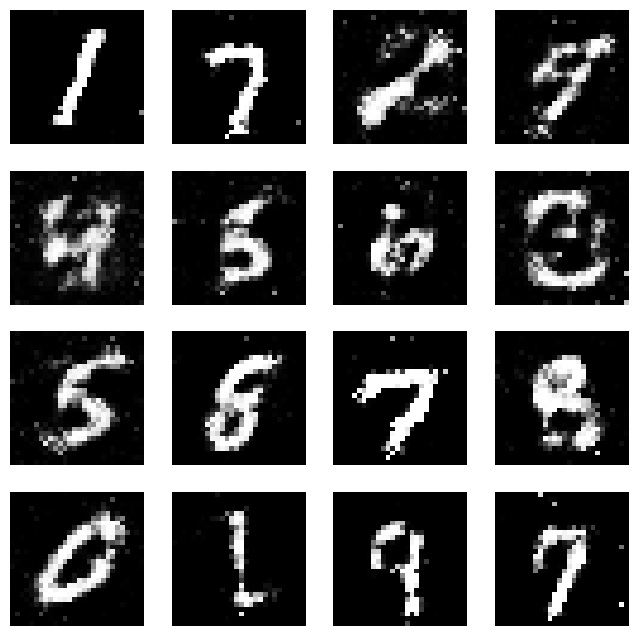

Epoch 40/200 (19.5%): [0/60032] (0.0%) D Error: 0.9093 G Error: 1.4402


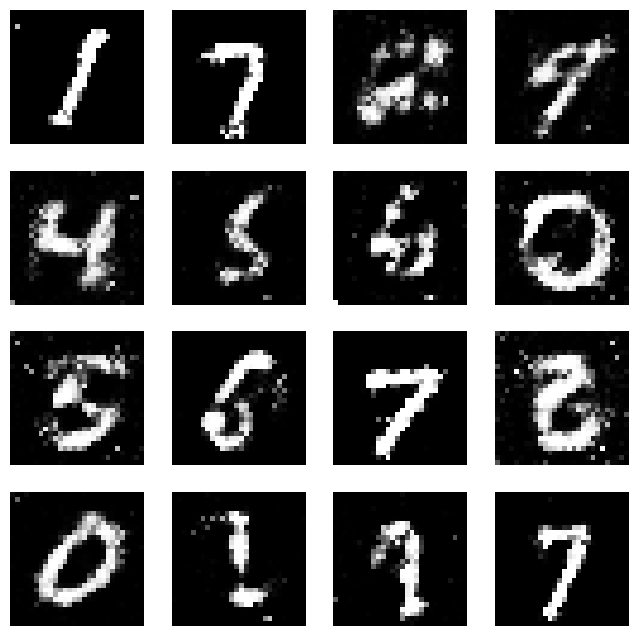

Epoch 41/200 (20.0%): [0/60032] (0.0%) D Error: 0.8294 G Error: 1.5261


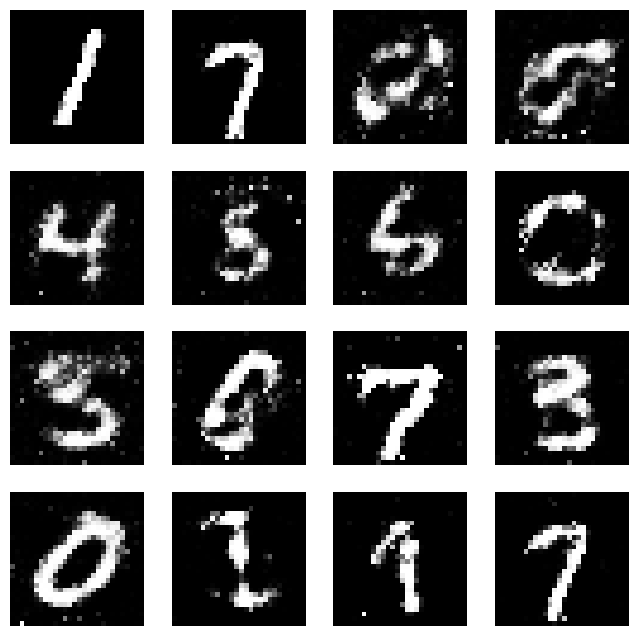

Epoch 42/200 (20.5%): [0/60032] (0.0%) D Error: 0.8666 G Error: 1.4397


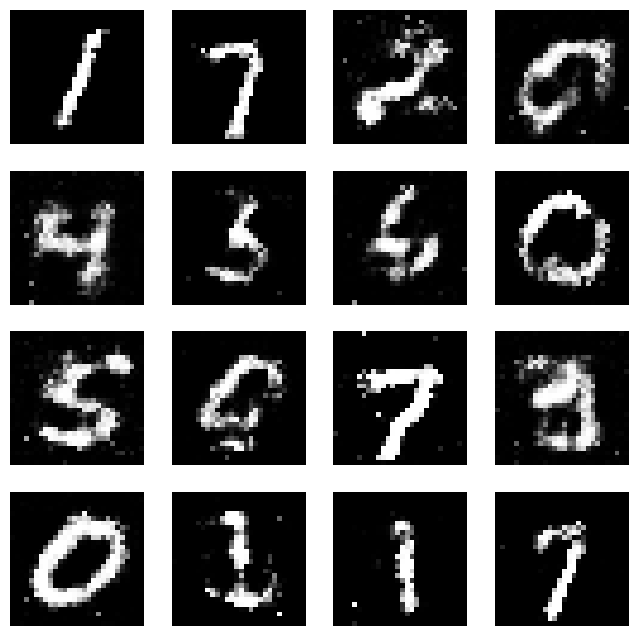

Epoch 43/200 (21.0%): [0/60032] (0.0%) D Error: 0.9967 G Error: 1.3210


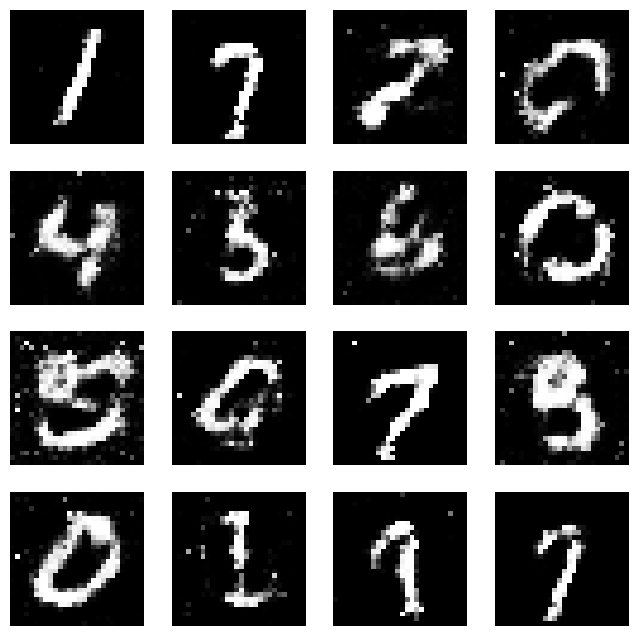

Epoch 44/200 (21.5%): [0/60032] (0.0%) D Error: 1.0219 G Error: 1.1383


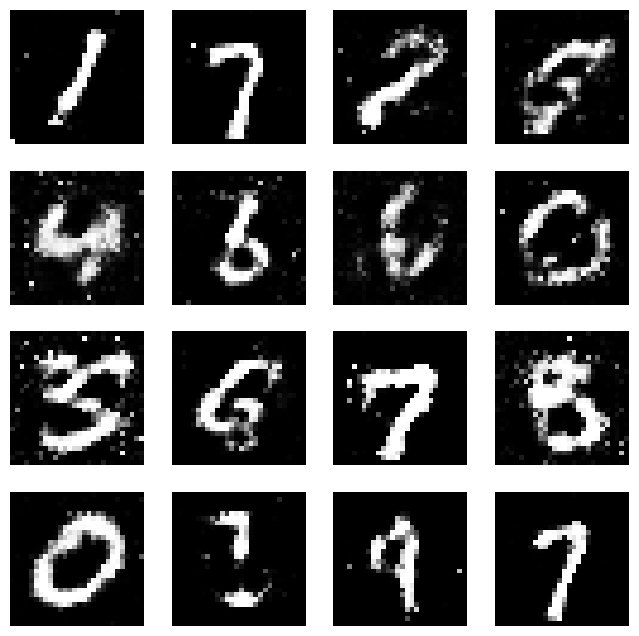

Epoch 45/200 (22.0%): [0/60032] (0.0%) D Error: 1.2142 G Error: 1.2785


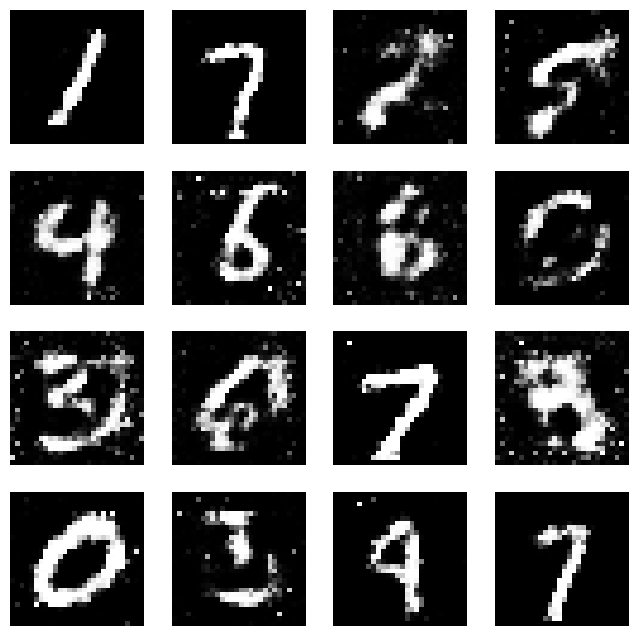

Epoch 46/200 (22.5%): [0/60032] (0.0%) D Error: 1.1109 G Error: 1.4625


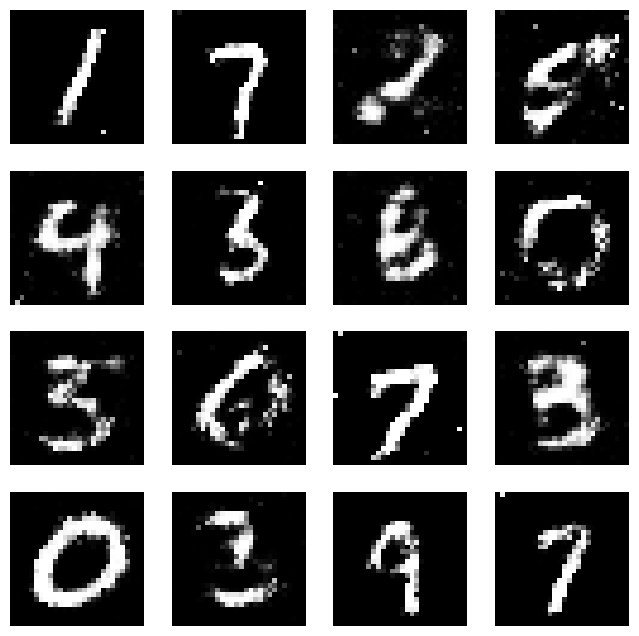

Epoch 47/200 (23.0%): [0/60032] (0.0%) D Error: 1.0463 G Error: 1.3390


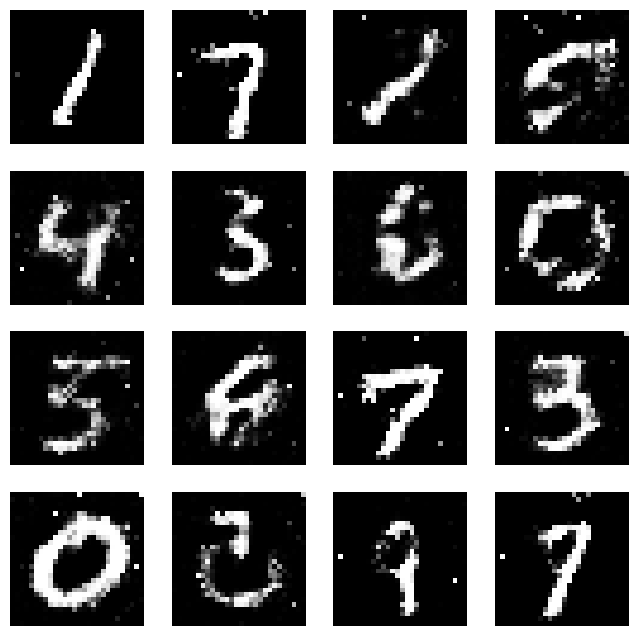

Epoch 48/200 (23.5%): [0/60032] (0.0%) D Error: 1.0017 G Error: 1.1792


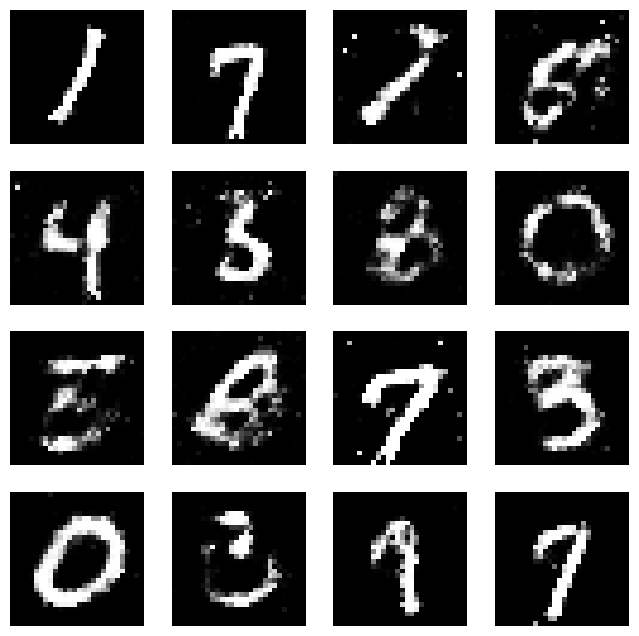

Epoch 49/200 (24.0%): [0/60032] (0.0%) D Error: 1.1170 G Error: 1.3804


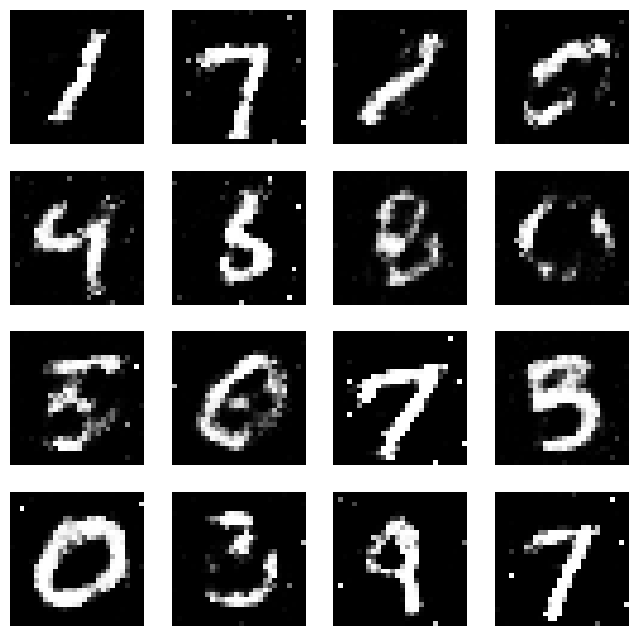

Epoch 50/200 (24.5%): [0/60032] (0.0%) D Error: 1.0228 G Error: 1.3555


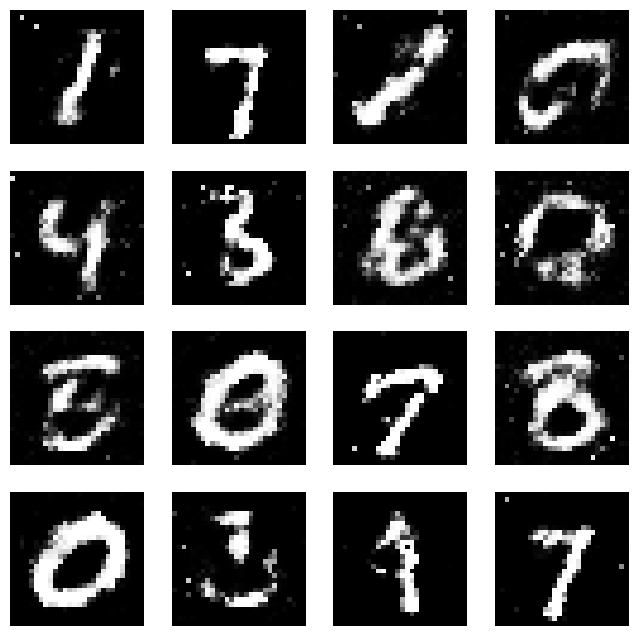

Epoch 51/200 (25.0%): [0/60032] (0.0%) D Error: 1.0764 G Error: 0.9603


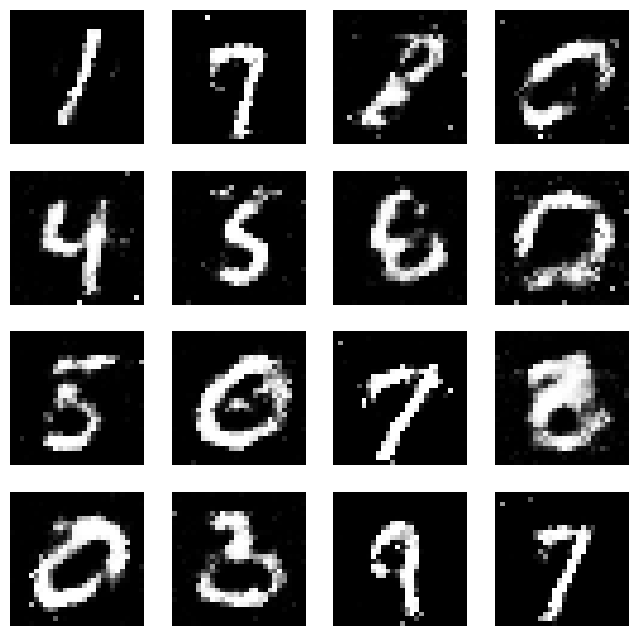

Epoch 52/200 (25.5%): [0/60032] (0.0%) D Error: 1.2862 G Error: 1.1688


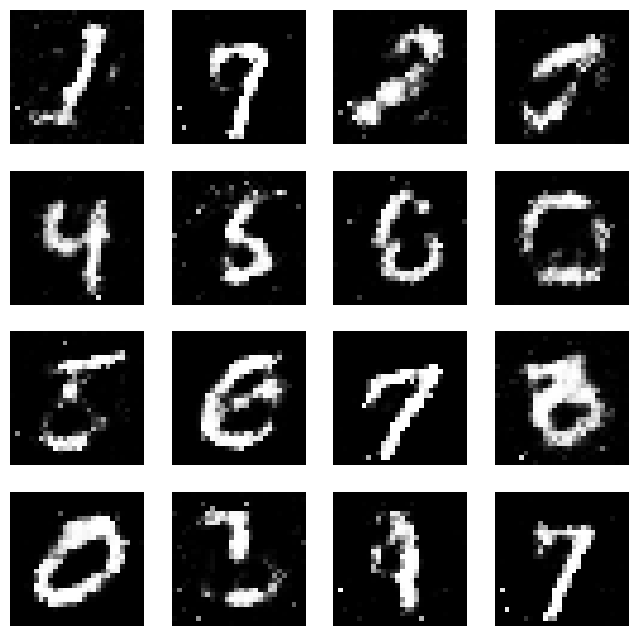

Epoch 53/200 (26.0%): [0/60032] (0.0%) D Error: 1.2010 G Error: 1.0293


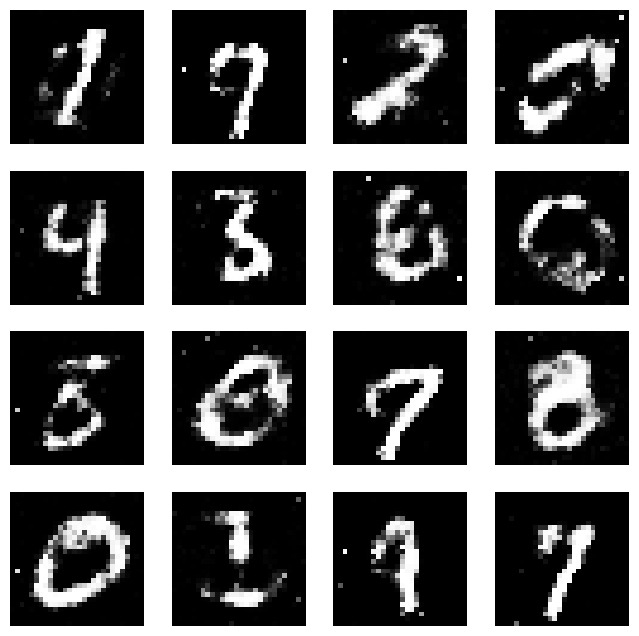

Epoch 54/200 (26.5%): [0/60032] (0.0%) D Error: 1.0765 G Error: 1.1500


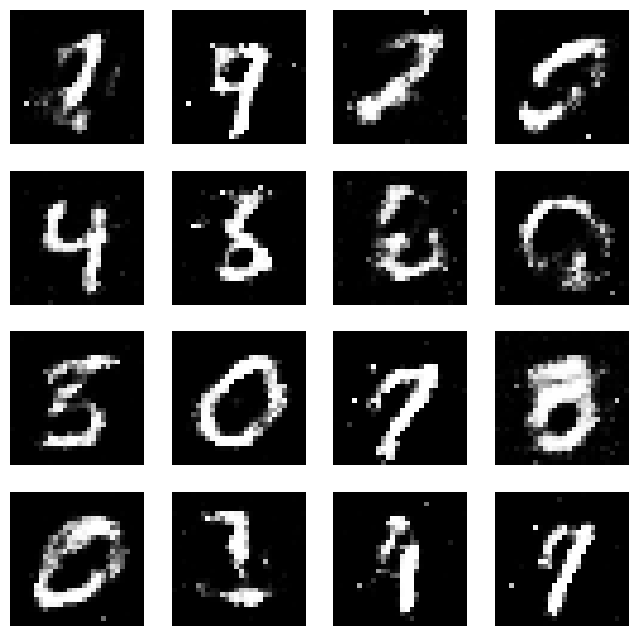

Epoch 55/200 (27.0%): [0/60032] (0.0%) D Error: 1.1011 G Error: 1.2307


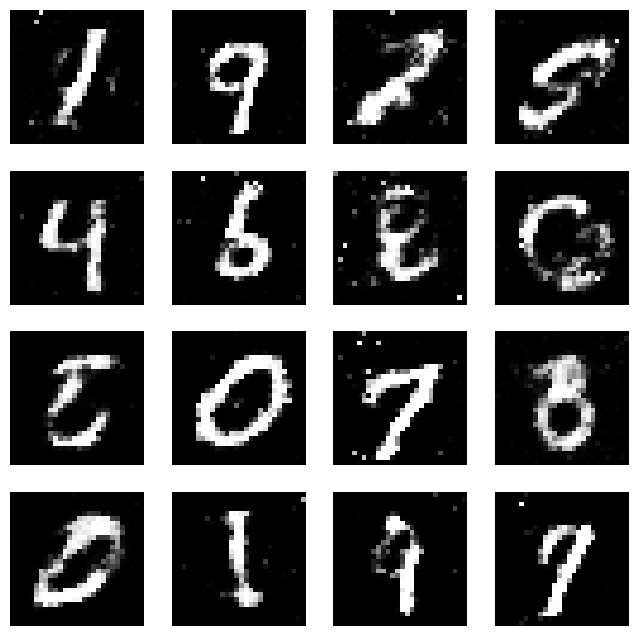

Epoch 56/200 (27.5%): [0/60032] (0.0%) D Error: 1.1698 G Error: 1.2466


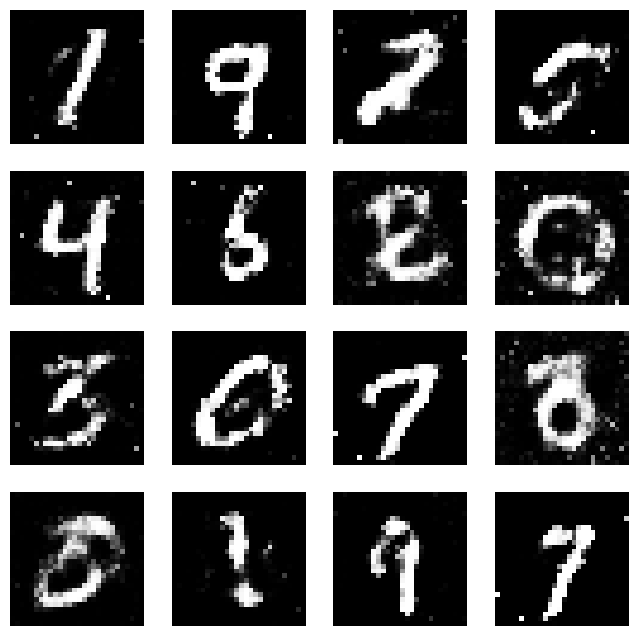

Epoch 57/200 (28.0%): [0/60032] (0.0%) D Error: 1.0159 G Error: 1.2208


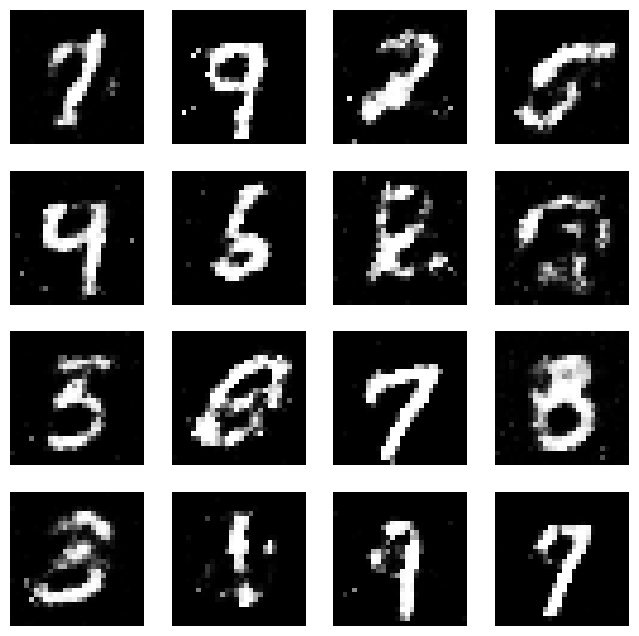

Epoch 58/200 (28.5%): [0/60032] (0.0%) D Error: 1.3073 G Error: 1.0845


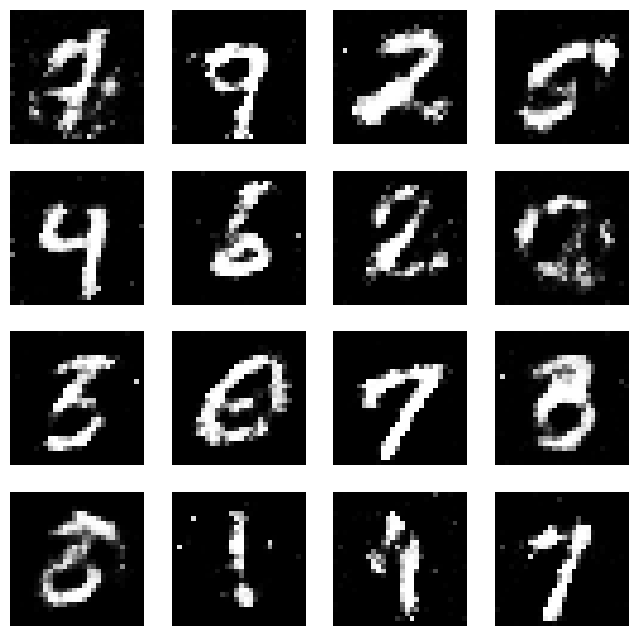

Epoch 59/200 (29.0%): [0/60032] (0.0%) D Error: 1.1897 G Error: 1.1681


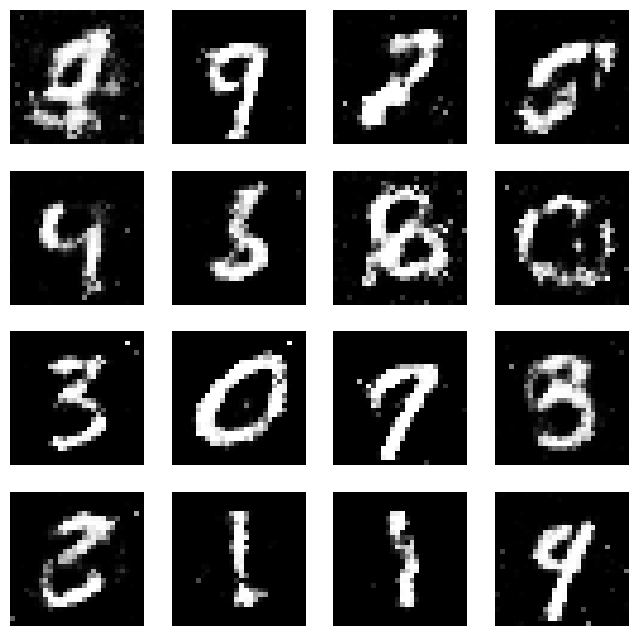

Epoch 60/200 (29.5%): [0/60032] (0.0%) D Error: 1.0730 G Error: 1.0552


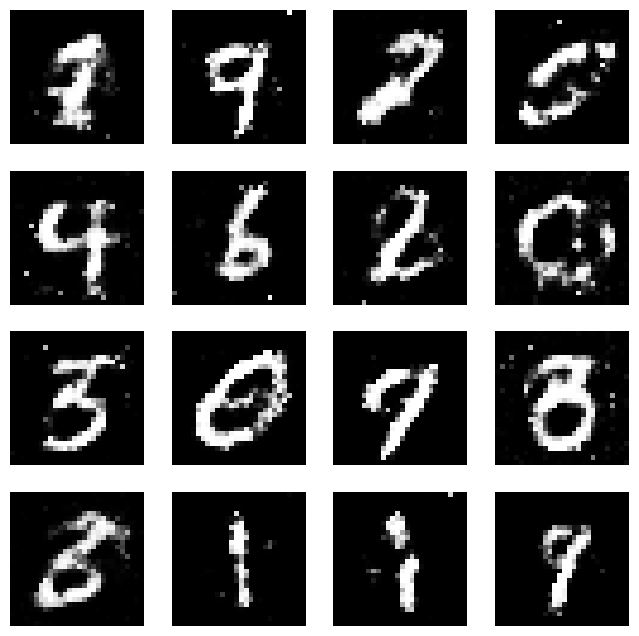

Epoch 61/200 (30.0%): [0/60032] (0.0%) D Error: 1.0692 G Error: 1.2599


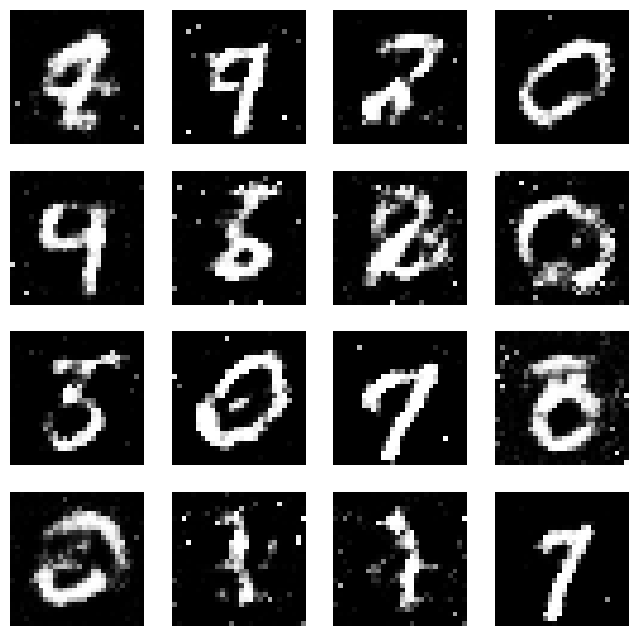

Epoch 62/200 (30.5%): [0/60032] (0.0%) D Error: 1.0766 G Error: 1.1569


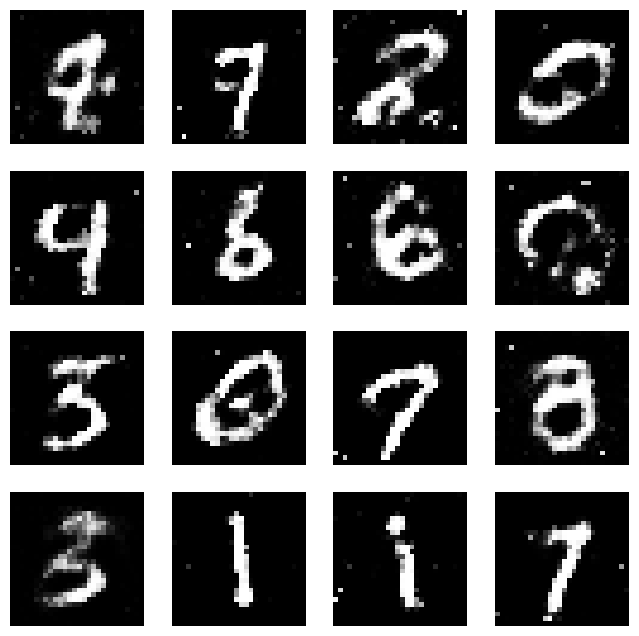

Epoch 63/200 (31.0%): [0/60032] (0.0%) D Error: 1.2762 G Error: 1.0054


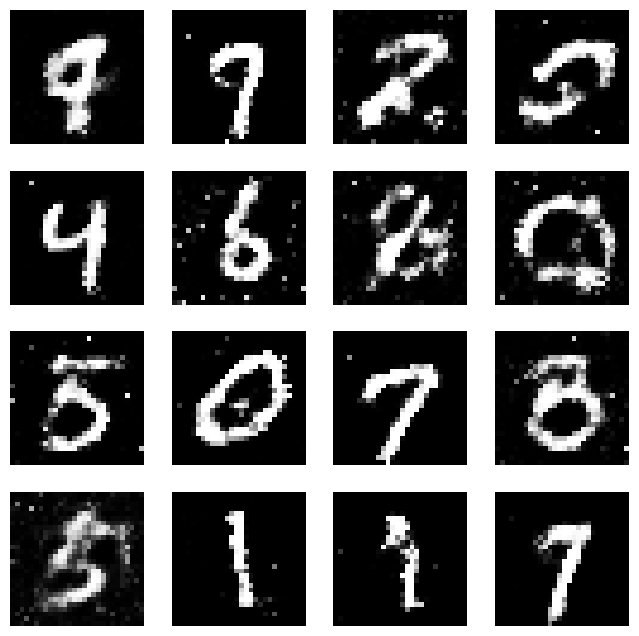

Epoch 64/200 (31.5%): [0/60032] (0.0%) D Error: 1.2139 G Error: 1.0005


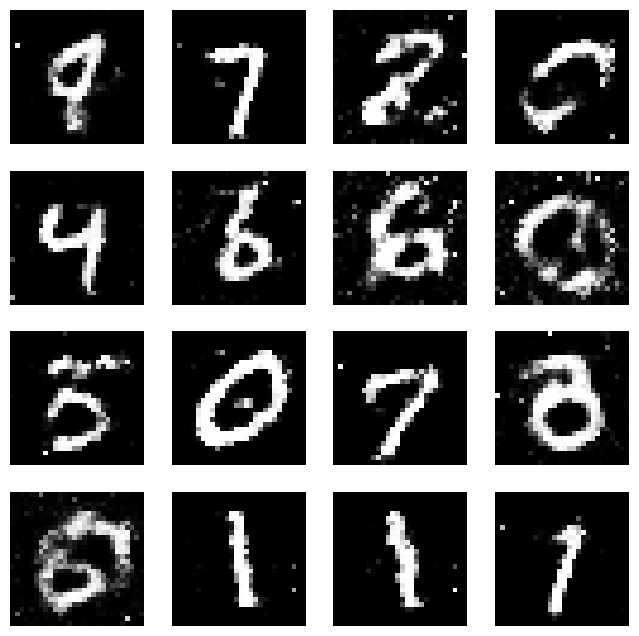

Epoch 65/200 (32.0%): [0/60032] (0.0%) D Error: 1.1524 G Error: 1.0076


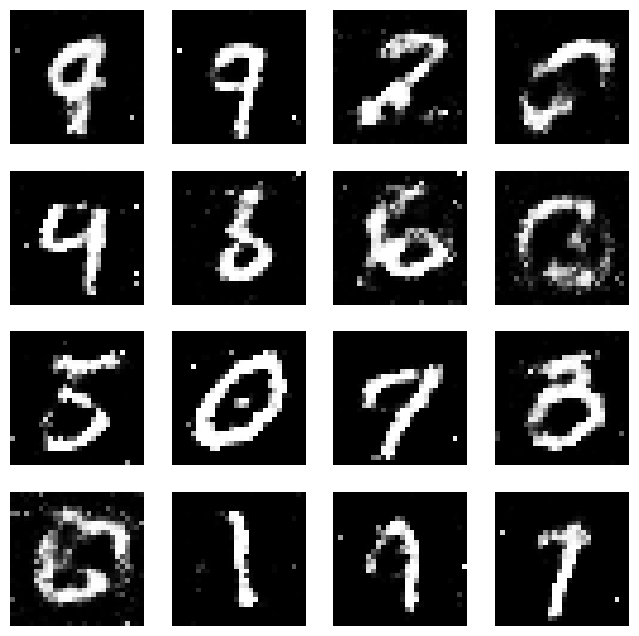

Epoch 66/200 (32.5%): [0/60032] (0.0%) D Error: 1.1489 G Error: 1.1271


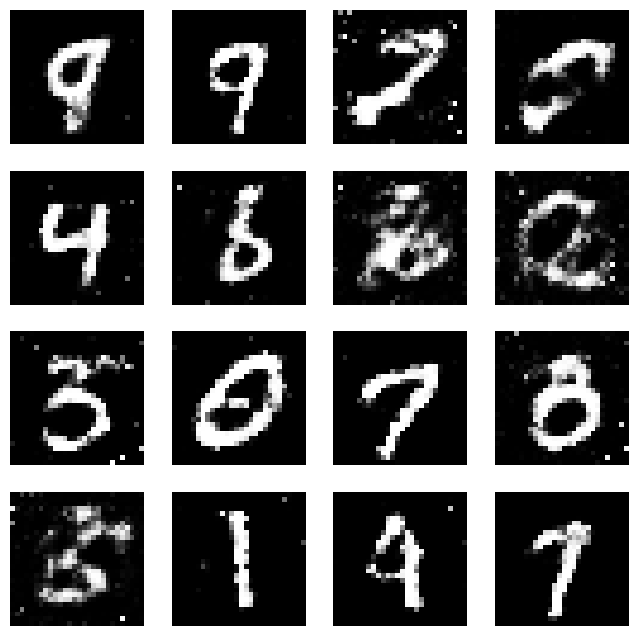

Epoch 67/200 (33.0%): [0/60032] (0.0%) D Error: 1.1071 G Error: 1.1180


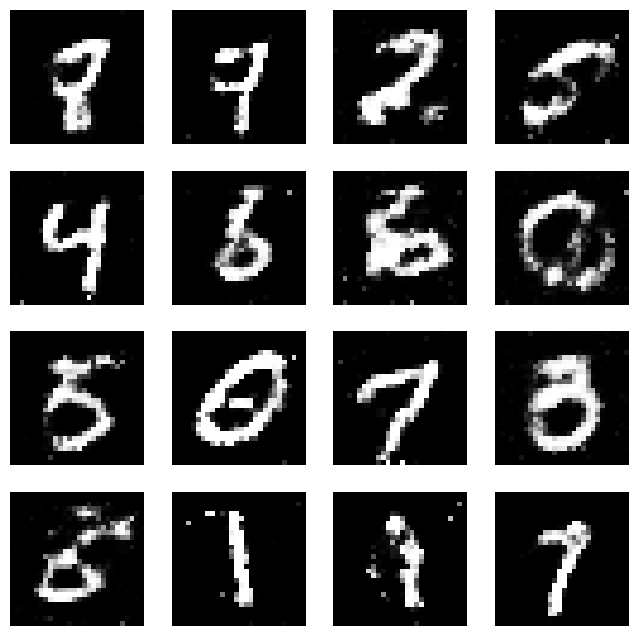

Epoch 68/200 (33.5%): [0/60032] (0.0%) D Error: 1.2440 G Error: 1.0435


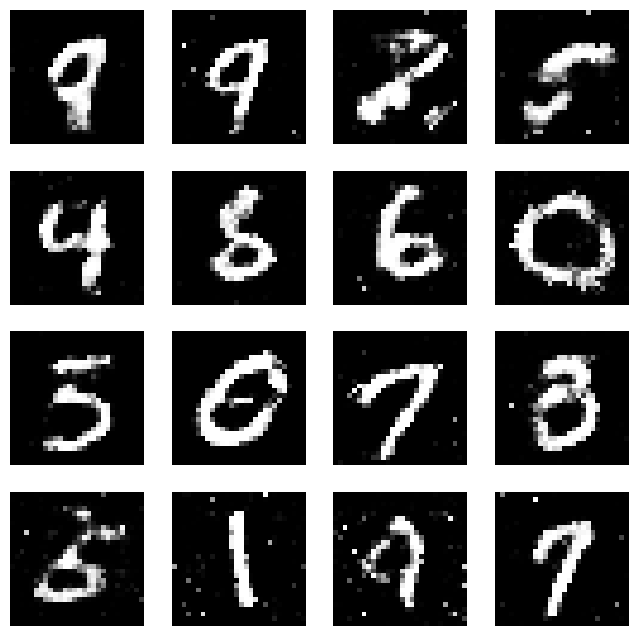

Epoch 69/200 (34.0%): [0/60032] (0.0%) D Error: 1.1782 G Error: 0.9797


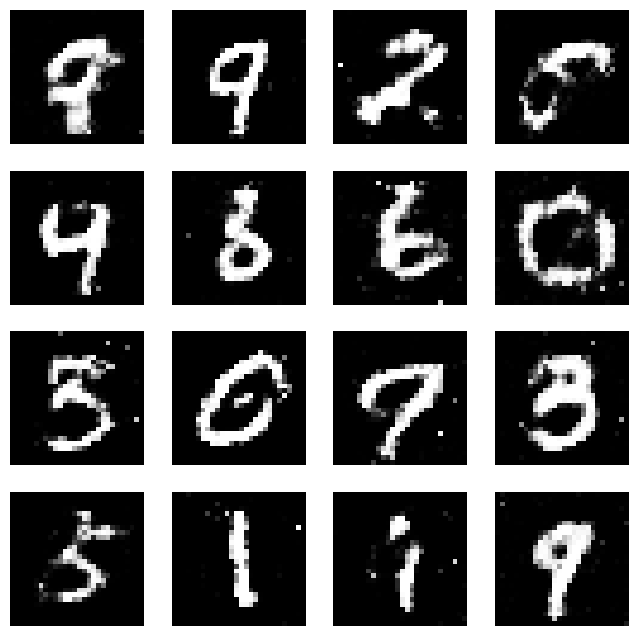

Epoch 70/200 (34.5%): [0/60032] (0.0%) D Error: 1.1507 G Error: 0.8818


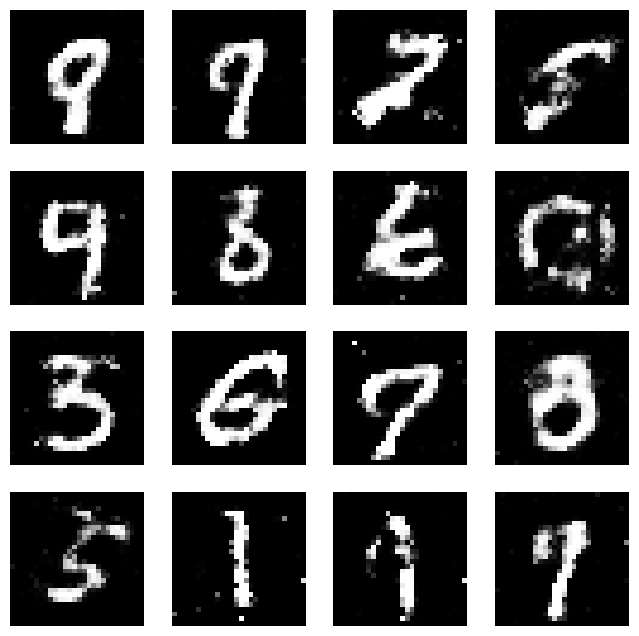

Epoch 71/200 (35.0%): [0/60032] (0.0%) D Error: 1.0428 G Error: 1.3639


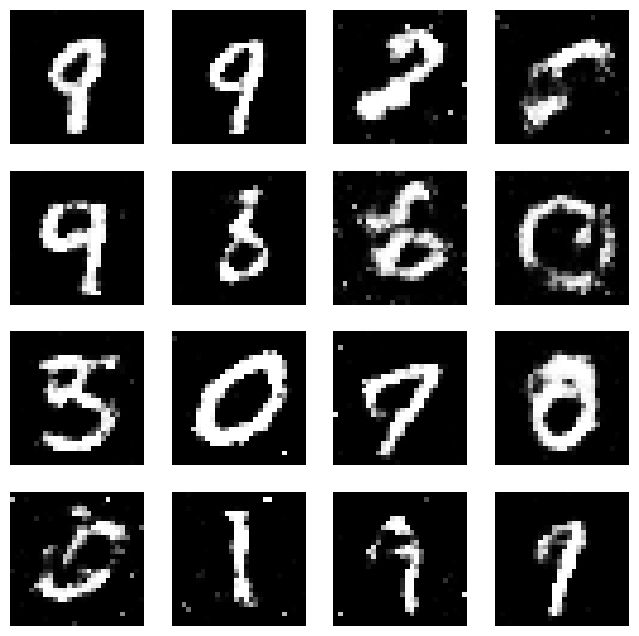

Epoch 72/200 (35.5%): [0/60032] (0.0%) D Error: 1.1452 G Error: 1.1040


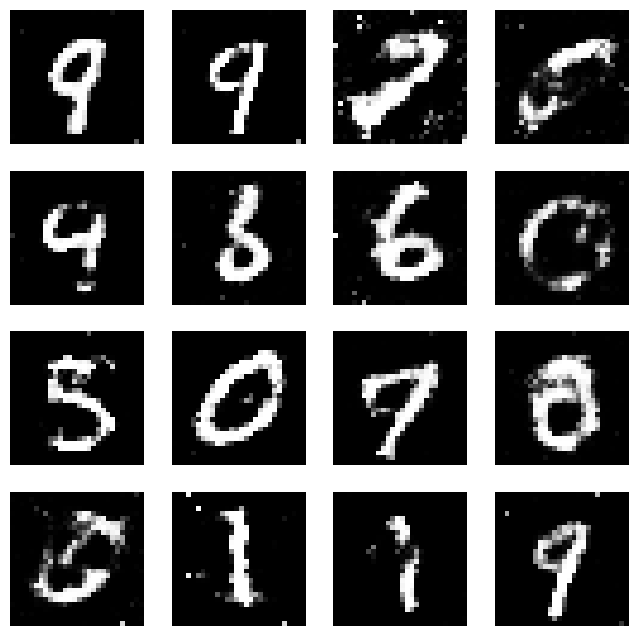

Epoch 73/200 (36.0%): [0/60032] (0.0%) D Error: 1.2110 G Error: 1.1401


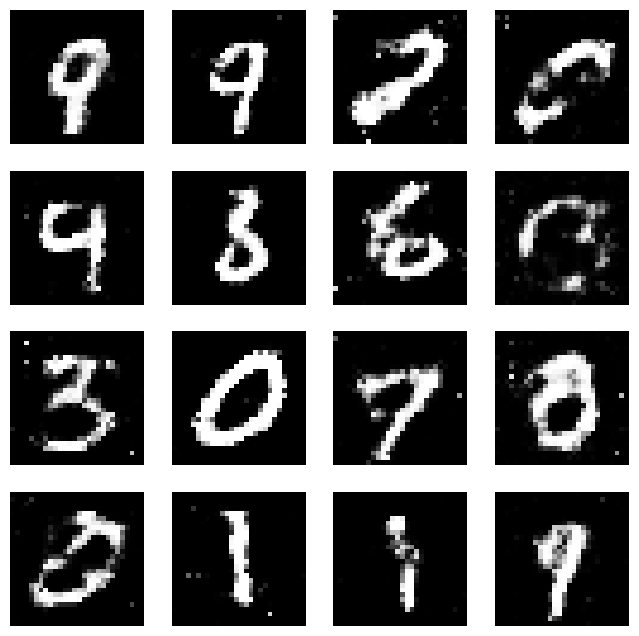

Epoch 74/200 (36.5%): [0/60032] (0.0%) D Error: 1.2035 G Error: 1.0345


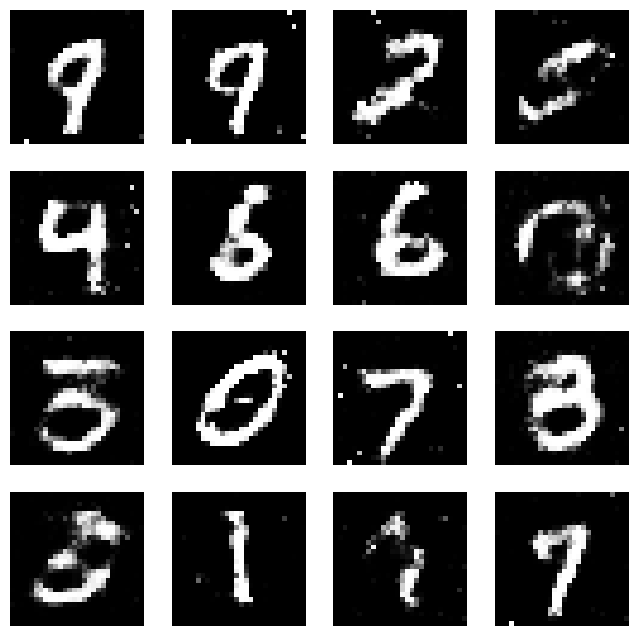

Epoch 75/200 (37.0%): [0/60032] (0.0%) D Error: 1.2284 G Error: 1.1302


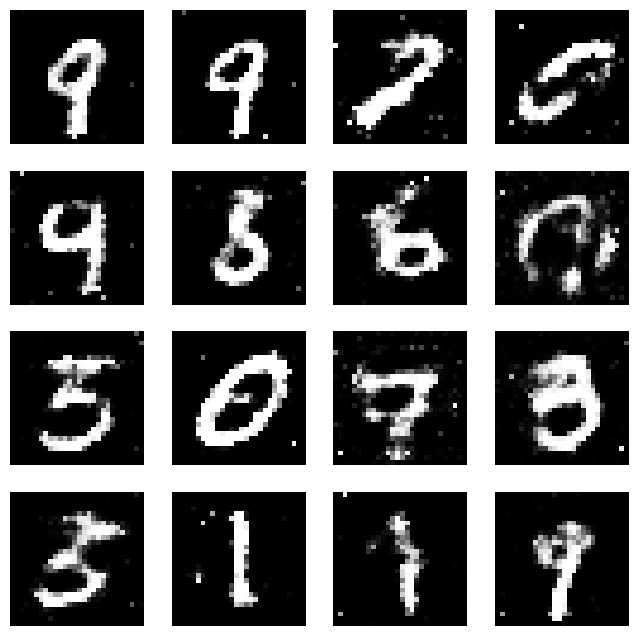

Epoch 76/200 (37.5%): [0/60032] (0.0%) D Error: 1.2134 G Error: 0.9363


KeyboardInterrupt: 

In [11]:
for epoch in range(EPOCHS):
    for batch_idx, (batch, _) in enumerate(train_loader):
        # === Train D ===
        real_data = Variable(imgs_to_vec(batch))
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake, = train_discriminator(
            discriminator, d_optimizer, loss, real_data, fake_data)
        # === Train G ===
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(
            discriminator, g_optimizer, loss, fake_data)
        # === Logging ===
        #log(d_error, g_error, epoch, batch_idx, len(data_loader))
        
        if (batch_idx % DISPLAY_EVERY) == 0:
            test_images = vec_to_imgs(generator(test_noise)).data.cpu()
            display_images(test_images)
            # Logging
            display_logs(epoch, EPOCHS, batch_idx, NUM_BATCHES,
                         d_error, g_error, d_pred_real, d_pred_fake)

# Compare

Use validation dataset to plot and compare the results of your trained models.

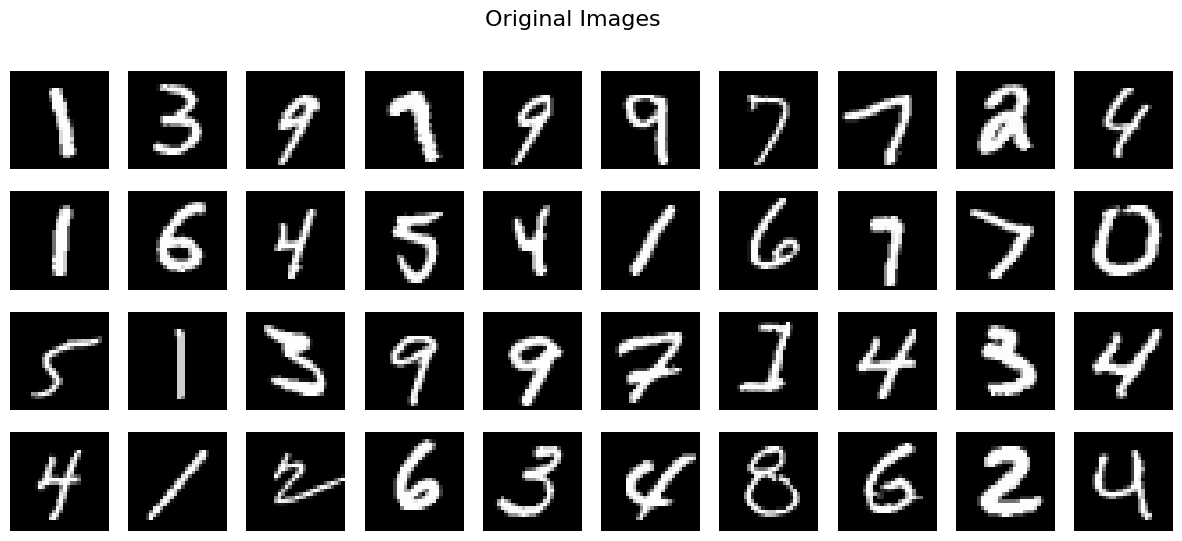

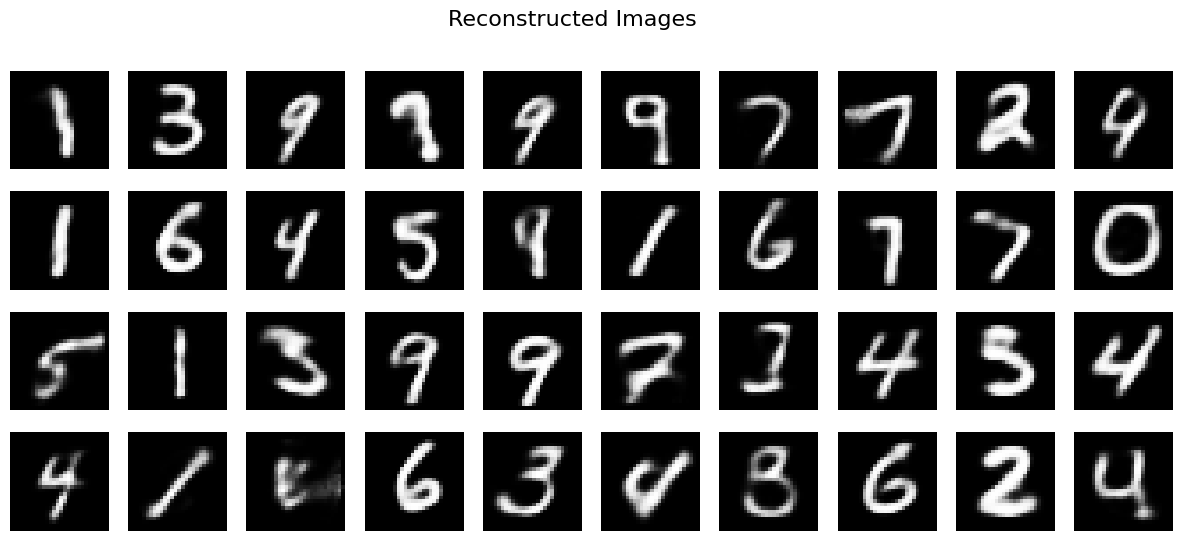

In [30]:
import matplotlib.pyplot as plt

def plot_comparison(vae, dataloader, num_images=40):
    vae.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)
    recon_images, _, _ = vae(images)

    # Detach from GPU and move to CPU for plotting
    images = images.cpu().detach().numpy()
    recon_images = recon_images.cpu().detach().numpy()

    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    for i in range(4):
        for j in range(10):
            idx = i * 10 + j
            if idx < num_images:
                axes[i, j].imshow(images[idx].reshape(28, 28), cmap='gray')
                axes[i, j].axis('off')
    plt.suptitle("Original Images", fontsize=16)
    plt.show()

    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    for i in range(4):
        for j in range(10):
            idx = i * 10 + j
            if idx < num_images:
                axes[i, j].imshow(recon_images[idx].reshape(28, 28), cmap='gray')
                axes[i, j].axis('off')
    plt.suptitle("Reconstructed Images", fontsize=16)
    plt.show()

# Assuming `val_loader` is defined and `model` is your trained VAE model
plot_comparison(model, val_loader)


In [26]:
def display_images2(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=10, figsize=(18,6))
    count = 0
    for y in range(4):
        for x in range(10):
            img = imgs[count].view(28, 28)
            axs[y][x].axis('off')
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    fig.suptitle('Reconstruction by GAN')
    plt.show()

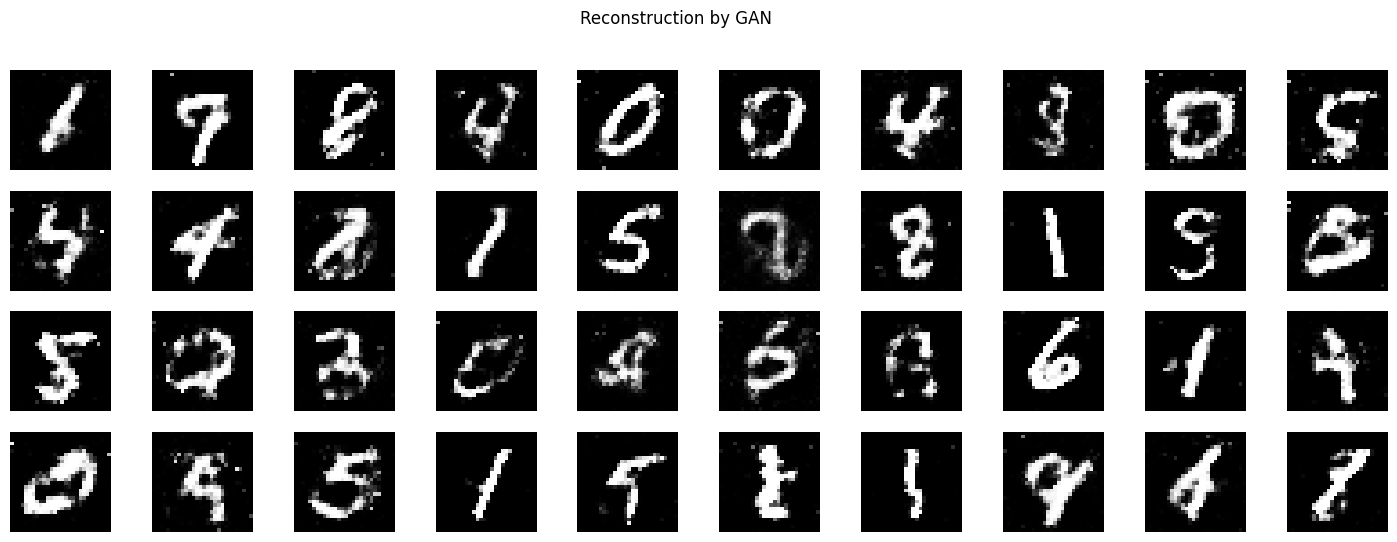

In [27]:
test_images = vec_to_imgs(generator(noise(40).to(device).to(device))).data.cpu()
display_images2(test_images)